<h1>Setup</h1>

In [44]:
import csv
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import warnings
import datetime as dt
import geopandas as gpd
import folium
import mapclassify
sns.set(color_codes=True)
from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
from lifelines import CoxPHFitter
cph = CoxPHFitter()
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
from random import sample
import time


warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
#creating functions that search parts of strings and clip values
def left(aString, howMany):
    if howMany <1:
        return ''
    else:
        return aString[:howMany]

def right(aString, howMany):
    if howMany <1:
        return ''
    else:
        return aString[-howMany:]

def mid(aString, startChar, howMany):
    if howMany < 1:
        return ''
    else:
        return aString[startChar:startChar+howMany]

In [4]:
def time_series_join(df1,df2): #function receives two dataframe objects
    ##### ATENTION ### this function needs the date-time fields to be named 'date'
    begin_df1 = df1.date.min() #checking min/max (first/last) dates in df1 
    end_df1 = df1.date.max()
    print("Begin move: ", begin_df1, "\nEnd move: ", end_df1)

    begin_df2 = df2.date.min() #checking min/max (first/last) dates in df2
    end_df2 = df2.date.max()
    print("Begin cases: ", begin_df2, "\nEnd cases: ", end_df2)

    if begin_df1 > begin_df2: #comparing dataframe 1 and 2 first date 
        begin_date = begin_df1
        begin_early = "DF 2" #I need to clip the dataset that has earlier dates

    else:
        begin_date = begin_df2
        begin_early = "DF 1"
    print("Begins earlier:",begin_early, "(should be clipped)")
    print(begin_date)

    if end_df1 < end_df2:
        end_date = end_df1
        end_later = "DF 2"
    else:
        end_date = end_df2
        end_later = "DF 1"
    print("Ends later:",end_later, "(should be clipped)")
    print(begin_date)

    if begin_early == "DF 2":
        df2 = df2[df2.date>=begin_date]
        print("DF 2 are clipped at", df2.date.min())
    elif begin_early == "DF 1":
        df1 = df1[df1.date>=begin_date]
        print("DF 1 are clipped at", df1.date.min())

    if end_later == "DF 2":
        df2 = df2[df2.date<=end_date]
        print("DF 2 are clipped at", df2.date.max())
    elif end_later == "DF 1":
        df1 = df1[df1.date<=end_date]
        print("DF 1 are clipped at", df1.date.max())
        
    return df1, df2

def time_series_clip(df,date_field,datemin, datemax=dt.datetime.today()): 
    ##### ATENTION ### this function needs the date-time fields to be named 'date'
    begin_df = df[date_field].min()
    end_df = df[date_field].max()
    print('Should begin', datemin, "Actual begin: ", begin_df, '\nShould end', datemax, "  Actual end: ", end_df)
    if begin_df < datemin: #if dataframe has dates earlier than the defined limit mindate
        df = df[df[date_field]>=datemin]
        
    if end_df > datemax:
        df = df[df[date_field]<=datemax]
        
    return df

<h1>Imports</h1>

<h2>Tabular data</h2>

In [11]:
import_dct = {'df1':{'filename':'dados-sindrome-gripal-esus-sao-paulo-sp-jan-ago-2020.csv',
                     'min_date':dt.datetime.strptime('2020-01-01','%Y-%m-%d'),
                     'max_date':dt.datetime.strptime('2020-08-31','%Y-%m-%d')},
              'df2':{'filename':'dados-sindrome-gripal-esus-sao-paulo-sp-set-dez-2020.csv',
                     'min_date':dt.datetime.strptime('2020-09-01','%Y-%m-%d'),
                     'max_date':dt.datetime.strptime('2020-12-31','%Y-%m-%d')},
              'df3':{'filename':'dados-sindrome-gripal-esus-sao-paulo-sp-jan-fev-2021.csv',
                     'min_date':dt.datetime.strptime('2021-01-01','%Y-%m-%d'),
                     'max_date':dt.datetime.strptime('2021-02-28','%Y-%m-%d')},
              'df4':{'filename':'dados-sindrome-gripal-esus-sao-paulo-sp-mar-abr-2021.csv',
                     'min_date':dt.datetime.strptime('2021-03-01','%Y-%m-%d'),
                     'max_date':dt.datetime.strptime('2021-04-30','%Y-%m-%d')},
              'df5':{'filename':'dados-sindrome-gripal-esus-sao-paulo-sp-mai-jun-2021.csv',
                     'min_date':dt.datetime.strptime('2021-05-01','%Y-%m-%d'),
                     'max_date':dt.datetime.strptime('2021-06-30','%Y-%m-%d')},
              'df6':{'filename':'dados-sindrome-gripal-esus-sao-paulo-sp-jul-ago-2021.csv',
                     'min_date':dt.datetime.strptime('2021-07-01','%Y-%m-%d'),
                     'max_date':dt.datetime.strptime('2021-08-31','%Y-%m-%d')},
              'df7':{'filename':'dados-sindrome-gripal-esus-sao-paulo-sp-set-nov-2021.csv',
                     'min_date':dt.datetime.strptime('2021-09-01','%Y-%m-%d'),
                     'max_date':dt.datetime.strptime('2021-11-30','%Y-%m-%d')}#, .date()
             }
file_path = Path('../../../02 data/SP SIVEP-GRIPE/')
dates_list = ['dataInicioSintomas','dataEncerramento']
cols_list = ['id', 'dataInicioSintomas','idade', 'sexo', 'racaCor',
             'etnia','bairro','setorCensitario','classificacaoFinalModificada', 'evolucaoCaso','dataEncerramento']
li = []
records = 0
for key, value in import_dct.items():
    #get URLs and import files
    url = file_path / import_dct[key]['filename']
    print(url)
    df = pd.read_csv(url,delimiter=';', encoding='utf-8',parse_dates=dates_list, 
                     usecols=cols_list, dtype={'setorCensitario':str})
    records = records + len(df.index)
    df['in_date'] = df.dataInicioSintomas #simplifying column names
    df['end_date'] = df.dataEncerramento #simplifying column names
    #include cleaning functions
    df = time_series_clip(df,'in_date',import_dct[key]['min_date'], 
                          import_dct[key]['max_date'])
    print('Now begins',df['in_date'].min(),'\nNow ends:',df['in_date'].max(), 
          '\nRecords add to:',records)
    
    #calculating dummy variables for covid infection and death
    df['covid'] = np.where(df['classificacaoFinalModificada'].
                           isin([1, 2, 3, 4]), 1, 0) #1 for any COVID classification, 0 if no classification
    df['death'] = np.where(df['evolucaoCaso'].
                           isin(['Óbito']), 1, 0) #1 for death, 0 for not death

    #after cleaning, add the new dataframe to the list
    li.append(df)
    
#compose a new dataframe from all elements in the list
cases_raw = pd.concat(li, axis=0, ignore_index=True)
cases_raw

../../../02 data/SP SIVEP-GRIPE/dados-sindrome-gripal-esus-sao-paulo-sp-jan-ago-2020.csv
Should begin 2020-01-01 00:00:00 Actual begin:  1998-05-18 00:00:00 
Should end 2020-08-31 00:00:00   Actual end:  2022-01-16 00:00:00
Now begins 2020-01-01 00:00:00 
Now ends: 2020-08-31 00:00:00 
Records add to: 887294
../../../02 data/SP SIVEP-GRIPE/dados-sindrome-gripal-esus-sao-paulo-sp-set-dez-2020.csv
Should begin 2020-09-01 00:00:00 Actual begin:  2014-02-05 00:00:00 
Should end 2020-12-31 00:00:00   Actual end:  2022-01-16 00:00:00
Now begins 2020-09-01 00:00:00 
Now ends: 2020-12-31 00:00:00 
Records add to: 1634216
../../../02 data/SP SIVEP-GRIPE/dados-sindrome-gripal-esus-sao-paulo-sp-jan-fev-2021.csv
Should begin 2021-01-01 00:00:00 Actual begin:  2020-01-01 00:00:00 
Should end 2021-02-28 00:00:00   Actual end:  2121-01-06 00:00:00
Now begins 2021-01-01 00:00:00 
Now ends: 2021-02-28 00:00:00 
Records add to: 2116046
../../../02 data/SP SIVEP-GRIPE/dados-sindrome-gripal-esus-sao-paulo

,id,idade,sexo,racaCor,etnia,bairro,setorCensitario,dataInicioSintomas,classificacaoFinalModificada,evolucaoCaso,dataEncerramento,in_date,end_date,covid,death
0,1627047285,56.0,Feminino,Parda,NaN,Vila Vera,355030868000124,2020-05-06,5.0,Cura,2020-06-30,2020-05-06,2020-06-30,0,0
1,1626852540,33.0,Masculino,Branca,NaN,SEM INFORMACAO,0,2020-03-12,2.0,NaN,NaT,2020-03-12,NaT,1,0
2,1626898870,62.0,Feminino,Parda,NaN,JARDIM SAPOPEMBA,355030873000096,2020-05-04,2.0,Cura,2020-08-13,2020-05-04,2020-08-13,1,0
3,SC3XWOMSGy,39.0,Masculino,NaN,NaN,Jardim Olympia,NaN,2020-05-22,1.0,NaN,NaT,2020-05-22,NaT,1,0
4,1626639304,34.0,Masculino,Parda,NaN,JARDIM PAULISTA,355030845000127,2020-05-28,6.0,Em tratamento domiciliar,2020-06-05,2020-05-28,2020-06-05,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865801,1645788989,36.0,Masculino,Ignorado,NaN,PARQUE SAO DOMINGOS,355030895000003,2021-11-20,1.0,NaN,NaT,2021-11-20,NaT,1,0
3865802,1646167088,13.0,Masculino,Branca,NaN,JARDIM SOUZA,355030846000316,2021-11-22,1.0,NaN,NaT,2021-11-22,NaT,1,0
3865803,1637240018,3.0,Masculino,Ignorado,NaN,SAO PAULO,99,2021-09-04,1.0,NaN,NaT,2021-09-04,NaT,1,0
3865804,1644655159,27.0,Masculino,Ignorado,NaN,AGUA BRANCA,355030848000032,2021-09-07,1.0,Ignorado,2021-10-04,2021-09-07,2021-10-04,1,0


<h4>SVI data</h4>

In [181]:
g_IVS_file = ('CVGI_LIM_SP_Sao Paulo IVS IDHM_UDH and census district_IPEA_2010_A.gpkg')
file_path = Path('../../../02 data/BR IPEA IVS 2000 and 2010/')

geo_url = file_path / g_IVS_file 
IVS_df = gpd.read_file(geo_url)
#IVS_df.columns.tolist()

In [182]:
IVS_df = IVS_df[:][['udh', 'nome_udh','ivs', 'ivs_infrae','ivs_capita', 'ivs_renda_', 'idhm', 'idhm_long', 'idhm_educ',
       'idhm_renda', 'populacao','rg_Name','CD_DIST','geometry']]
IVS_df.columns = ['udh', 'nome_udh','ivs', 'ivs_infrae','ivs_capita', 'ivs_income', 'idhm', 'idhm_long', 'idhm_educ',
       'idhm_income','population','ring','ibge_code','geometry']
IVS_df.head()

,udh,nome_udh,ivs,ivs_infrae,ivs_capita,ivs_income,idhm,idhm_long,idhm_educ,idhm_income,population,ring,ibge_code,geometry
0,1.351880e+12,Várzea do Palácio,0.339,0.240,0.442,0.337,0.661,0.760,0.582,0.652,28857,central,351880010,"MULTIPOLYGON (((341738.988 7399577.772, 341750..."
1,1.351880e+12,Itapegica : Escola Estadual Coronel Ary Gomes ...,0.242,0.355,0.195,0.177,0.831,0.907,0.792,0.798,5591,central,351880005,"MULTIPOLYGON (((342179.361 7400016.536, 342174..."
2,1.351880e+12,Vila Flora,0.414,0.412,0.466,0.365,0.653,0.742,0.594,0.633,1768,central,351880005,"MULTIPOLYGON (((341116.700 7401331.046, 341109..."
3,1.351880e+12,Itapegica : Comunidade Saigo,0.416,0.412,0.472,0.365,0.653,0.742,0.594,0.633,573,central,351880005,"MULTIPOLYGON (((341051.300 7401984.302, 341042..."
4,1.351880e+12,Itapegica : São Rafael,0.308,0.239,0.419,0.265,0.745,0.830,0.715,0.696,5980,central,351880005,"MULTIPOLYGON (((341250.153 7402601.435, 341236..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,1.355031e+12,Fazenda Itaim : Rua Manuel Rodrigues Santiago ...,0.408,0.411,0.464,0.348,0.653,0.741,0.595,0.632,1861,metro-periphery,355030836,"MULTIPOLYGON (((359572.554 7398698.405, 359504..."
3125,1.355031e+12,Cidade Kemel,0.412,0.411,0.477,0.348,0.653,0.741,0.595,0.632,1240,metro-periphery,355030836,"MULTIPOLYGON (((360619.718 7400035.600, 360619..."
3126,1.355031e+12,Das Meliunas,0.407,0.411,0.462,0.348,0.653,0.741,0.595,0.632,2311,metro-periphery,355030836,"MULTIPOLYGON (((360186.483 7400412.085, 360144..."
3127,1.355031e+12,Jardim Das Oliveiras : Estação Jardim Romano,0.407,0.411,0.462,0.348,0.653,0.741,0.595,0.632,2015,metro-periphery,355030836,"MULTIPOLYGON (((358768.055 7401860.806, 358750..."


In [183]:
def label_reg(row):
    if row['ring'] == 'central':
        return 1
    if row['ring'] == 'inner-periphery':
        return 2
    if row['ring'] == 'outer-periphery':
        return 3
    if row['ring'] == 'metro-periphery':
        return 4
    return 5

In [184]:
IVS_df['reg'] = IVS_df.apply(lambda row: label_reg(row), axis=1)
IVS_df

,udh,nome_udh,ivs,ivs_infrae,ivs_capita,ivs_income,idhm,idhm_long,idhm_educ,idhm_income,population,ring,ibge_code,geometry,reg
0,1.351880e+12,Várzea do Palácio,0.339,0.240,0.442,0.337,0.661,0.760,0.582,0.652,28857,central,351880010,"MULTIPOLYGON (((341738.988 7399577.772, 341750...",1
1,1.351880e+12,Itapegica : Escola Estadual Coronel Ary Gomes ...,0.242,0.355,0.195,0.177,0.831,0.907,0.792,0.798,5591,central,351880005,"MULTIPOLYGON (((342179.361 7400016.536, 342174...",1
2,1.351880e+12,Vila Flora,0.414,0.412,0.466,0.365,0.653,0.742,0.594,0.633,1768,central,351880005,"MULTIPOLYGON (((341116.700 7401331.046, 341109...",1
3,1.351880e+12,Itapegica : Comunidade Saigo,0.416,0.412,0.472,0.365,0.653,0.742,0.594,0.633,573,central,351880005,"MULTIPOLYGON (((341051.300 7401984.302, 341042...",1
4,1.351880e+12,Itapegica : São Rafael,0.308,0.239,0.419,0.265,0.745,0.830,0.715,0.696,5980,central,351880005,"MULTIPOLYGON (((341250.153 7402601.435, 341236...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,1.355031e+12,Fazenda Itaim : Rua Manuel Rodrigues Santiago ...,0.408,0.411,0.464,0.348,0.653,0.741,0.595,0.632,1861,metro-periphery,355030836,"MULTIPOLYGON (((359572.554 7398698.405, 359504...",4
3125,1.355031e+12,Cidade Kemel,0.412,0.411,0.477,0.348,0.653,0.741,0.595,0.632,1240,metro-periphery,355030836,"MULTIPOLYGON (((360619.718 7400035.600, 360619...",4
3126,1.355031e+12,Das Meliunas,0.407,0.411,0.462,0.348,0.653,0.741,0.595,0.632,2311,metro-periphery,355030836,"MULTIPOLYGON (((360186.483 7400412.085, 360144...",4
3127,1.355031e+12,Jardim Das Oliveiras : Estação Jardim Romano,0.407,0.411,0.462,0.348,0.653,0.741,0.595,0.632,2015,metro-periphery,355030836,"MULTIPOLYGON (((358768.055 7401860.806, 358750...",4


<h2>GeoData</h2>

importing census tracts shapefile

In [6]:
geo_file = ('SP_Setores_2019.shp')
file_path = Path('../../../02 data/BR IBGE censo 2019/')

geo_url = file_path / geo_file 
gdf = gpd.read_file(geo_url)

In [7]:
#importing the list of cities in the Metro Region of SP
url = Path("../../../23 colab/2022 05 WP2 dataset/02 data/CVGI_LIM_IBGE_RM SP municipalities_2010.csv") #home URL

rmsp = pd.read_csv(url, encoding='utf-8',dtype = {'CD_GEOCODM':str,'ID':str})
listrmsp = rmsp.CD_GEOCODM.to_list()
print(listrmsp[1],type(listrmsp[1]), len(listrmsp))
rmsp.head()

3505708 <class 'str'> 39


,ID,CD_GEOCODM,NM_MUNICIP
0,1771,3503901,ARUJÁ
1,1791,3505708,BARUERI
2,1801,3506607,BIRITIBA-MIRIM
3,1828,3509007,CAIEIRAS
4,1830,3509205,CAJAMAR


Optional rings info

In [8]:
geo_file = ('CVGI_SP_census tracts RMSP_rings_2019 A.shp')
file_path = Path('../GIS/')

geo_url = file_path / geo_file 
gdf_rings = gpd.read_file(geo_url)

In [9]:
geo_file = ('CVGI_RMSP census districts_2019 A.gpkg')
file_path = Path('../GIS/')

geo_url = file_path / geo_file 
gdf_districts_rmsp = gpd.read_file(geo_url)

<h1>Data preparation</h1>

<h2>Tabular data preparation</h2>

In [27]:
cases = time_series_clip(cases_raw,'end_date',import_dct['df1']['min_date'],import_dct['df7']['max_date'])
print('--------------------------------------',
      '\nSymptoms DF begins:     ',cases.in_date.min(),
      '\nSymptoms DF ends:       ',cases.in_date.max(),
      '\nEvolution DF begins: ',cases.end_date.min(),
      '\nEvolution DF ends:   ',cases.end_date.max(),
      '\nDF between dates length:   ',len(cases))
cases = cases[((cases.setorCensitario != '0')&(cases.setorCensitario != '99')&(cases.setorCensitario != np.nan))]
cases.dropna(axis=0,subset=['classificacaoFinalModificada','setorCensitario',],how="any",inplace=True)
cases.drop(axis=1,columns=['dataInicioSintomas','dataEncerramento'], inplace=True)
print('DF with census tract length:   ',len(cases))
cases

Should begin 2020-01-01 00:00:00 Actual begin:  1921-07-31 00:00:00 
Should end 2021-11-30 00:00:00   Actual end:  2022-01-18 00:00:00
-------------------------------------- 
Cases DF begins:      2020-01-01 00:00:00 
Cases DF ends:        2021-11-30 00:00:00 
Evolution DF begins:  2020-01-01 00:00:00 
Evolution DF ends:    2021-11-30 00:00:00 
DF between dates length:    2020798
DF with census tract length:    1948601


,id,idade,sexo,racaCor,etnia,bairro,setorCensitario,classificacaoFinalModificada,evolucaoCaso,in_date,end_date,covid,death
0,1627047285,56.0,Feminino,Parda,NaN,Vila Vera,355030868000124,5.0,Cura,2020-05-06,2020-06-30,0,0
2,1626898870,62.0,Feminino,Parda,NaN,JARDIM SAPOPEMBA,355030873000096,2.0,Cura,2020-05-04,2020-08-13,1,0
4,1626639304,34.0,Masculino,Parda,NaN,JARDIM PAULISTA,355030845000127,6.0,Em tratamento domiciliar,2020-05-28,2020-06-05,0,0
5,1626666391,52.0,Masculino,Branca,NaN,SAPOPEMBA,355030876000164,2.0,Cura,2020-05-27,2020-06-19,1,0
6,1626666374,46.0,Masculino,NaN,NaN,CERQUEIRA CESAR,355030845000206,1.0,Cura,2020-05-04,2020-08-10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865754,1644638716,32.0,Feminino,Ignorado,NaN,ITAIM PAULISTA,355030884000002,6.0,Em tratamento domiciliar,2021-09-28,2021-09-29,0,0
3865769,1637251934,61.0,Masculino,Ignorado,NaN,ALTO DE PINHEIROS,355030802000025,1.0,Cura,2021-09-06,2021-10-18,1,0
3865779,1645198920,28.0,Feminino,Ignorado,NaN,SAO PAULO,355030835000041,1.0,Ignorado,2021-09-19,2021-10-19,1,0
3865784,1645183300,28.0,Feminino,Ignorado,NaN,PINHEIROS,355030845000168,1.0,Ignorado,2021-09-21,2021-10-13,1,0


In [76]:
%%time
cases['in_week_id'] = cases['in_date'].dt.isocalendar().week
cases['in_year_id'] = cases['in_date'].dt.isocalendar().year
cases['end_week_id'] = cases['end_date'].dt.isocalendar().week
cases['end_year_id'] = cases['end_date'].dt.isocalendar().year
cases['in_epi_week'] = ""
cases['in_epi_week'] = np.where(cases['in_week_id']<10, cases.in_year_id.astype('str') + '.0' + cases.in_week_id.astype('str'), cases.in_year_id.astype('str') + '.' + cases.in_week_id.astype('str'))
cases['end_epi_week'] = ""
cases['end_epi_week'] = np.where(cases['end_week_id']<10, cases.end_year_id.astype('str') + '.0' + cases.end_week_id.astype('str'), cases.end_year_id.astype('str') + '.' + cases.end_week_id.astype('str'))
cases['duration'] = np.where(cases['end_date']>cases['in_date'],(cases['end_date']-cases['in_date']).dt.days,0)
#cases['acc_deaths'] = cases[['setorCensitario', 'death']].groupby('setorCensitario').cumsum()
cases.drop(axis=1,columns=['in_week_id','in_year_id','end_week_id','end_year_id'],inplace=True)
in_weeks_dict = {}
c = 1
for i in cases.in_epi_week.unique():
    in_weeks_dict[i] = c
    c = c+1
cases['in_week_col'] = cases.in_epi_week.replace(in_weeks_dict)    
end_weeks_dict = {}
d = 0
for i in cases.end_epi_week.unique():
    end_weeks_dict[i] = d
    d = d+1
cases['end_epi_col'] = cases.end_epi_week.replace(end_weeks_dict)
cases['epi_week_date'] = ".0"
cases['epi_week_date'] = cases.end_epi_week.astype("str").str.pad(7, side='right', fillchar='0') + cases.epi_week_date
cases['epi_week_date'] = pd.to_datetime(cases['epi_week_date'],format='%Y.%W.%w')

cases

,id,idade,sexo,racaCor,etnia,bairro,setorCensitario,classificacaoFinalModificada,evolucaoCaso,in_date,end_date,covid,death,in_epi_week,end_epi_week,duration,acc_deaths,in_week_col,end_epi_col,epi_week_date
0,1627047285,56.0,Feminino,Parda,NaN,Vila Vera,355030868000124,5.0,Cura,2020-05-06,2020-06-30,0,0,2020.19,2020.27,55,0,1,0,2020-07-12
2,1626898870,62.0,Feminino,Parda,NaN,JARDIM SAPOPEMBA,355030873000096,2.0,Cura,2020-05-04,2020-08-13,1,0,2020.19,2020.33,101,0,1,1,2020-08-23
4,1626639304,34.0,Masculino,Parda,NaN,JARDIM PAULISTA,355030845000127,6.0,Em tratamento domiciliar,2020-05-28,2020-06-05,0,0,2020.22,2020.23,8,0,2,2,2020-06-14
5,1626666391,52.0,Masculino,Branca,NaN,SAPOPEMBA,355030876000164,2.0,Cura,2020-05-27,2020-06-19,1,0,2020.22,2020.25,23,0,2,3,2020-06-28
6,1626666374,46.0,Masculino,NaN,NaN,CERQUEIRA CESAR,355030845000206,1.0,Cura,2020-05-04,2020-08-10,1,0,2020.19,2020.33,98,0,1,1,2020-08-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865754,1644638716,32.0,Feminino,Ignorado,NaN,ITAIM PAULISTA,355030884000002,6.0,Em tratamento domiciliar,2021-09-28,2021-09-29,0,0,2021.39,2021.39,1,0,90,84,2021-10-03
3865769,1637251934,61.0,Masculino,Ignorado,NaN,ALTO DE PINHEIROS,355030802000025,1.0,Cura,2021-09-06,2021-10-18,1,0,2021.36,2021.42,42,1,100,74,2021-10-24
3865779,1645198920,28.0,Feminino,Ignorado,NaN,SAO PAULO,355030835000041,1.0,Ignorado,2021-09-19,2021-10-19,1,0,2021.37,2021.42,30,0,89,74,2021-10-24
3865784,1645183300,28.0,Feminino,Ignorado,NaN,PINHEIROS,355030845000168,1.0,Ignorado,2021-09-21,2021-10-13,1,0,2021.38,2021.41,22,0,91,98,2021-10-17


<h3>Preparing data by tract</h3>

<h4>by week, with end date</h4>

In [135]:
cases_week_tract_sum = cases[:][['end_epi_week','setorCensitario','covid',
                                 'death']].groupby(['setorCensitario','end_epi_week'])[['covid','death']].sum() #,'acc_deaths'
cases_week_tract_count =  cases[:][['end_epi_week','setorCensitario','sexo','racaCor',
                                    'etnia']].groupby(['setorCensitario','end_epi_week'])[['sexo','racaCor','etnia']].count()
cases_week_tract_mean = cases[:][['end_epi_week','setorCensitario','idade']].groupby(['setorCensitario','end_epi_week'])[['idade']].mean()
cases_week_tract_count

sexo  racaCor  etnia
setorCensitario end_epi_week                      
355030801000001 2020.17          1        0      0
                2020.23          1        1      0
                2020.24          1        0      0
                2020.25          3        2      0
                2020.26          2        1      0
...                            ...      ...    ...
355030896000247 2021.36          1        1      0
                2021.37          1        1      0
                2021.39          3        3      0
                2021.40          1        1      0
                2021.45          2        2      0

[644027 rows x 3 columns]

In [139]:
new_index = pd.MultiIndex.from_product(cases_week_tract_sum.index.levels) #generating an index of all possible dates x tracts combination

cases_week_tract_sum = cases_week_tract_sum.reindex(new_index) #setting the index of the sum df to the complete index
cases_week_tract_count = cases_week_tract_count.reindex(new_index)

cases_week_tract_sum = cases_week_tract_sum.fillna(0).astype(int) #filling in missing values, as these are new cases/deaths, we can assume they are 0
cases_week_tract_count = cases_week_tract_count.ffill().fillna(0) #filling in missing values, they should be 0 to begin with, then proceed as the last non-nan value

cases_week_tract_count

sexo  racaCor  etnia
setorCensitario end_epi_week                      
355030801000001 2020.01        0.0      0.0    0.0
                2020.02        0.0      0.0    0.0
                2020.03        0.0      0.0    0.0
                2020.04        0.0      0.0    0.0
                2020.05        0.0      0.0    0.0
...                            ...      ...    ...
355030896000247 2021.44        1.0      1.0    0.0
                2021.45        2.0      2.0    0.0
                2021.46        2.0      2.0    0.0
                2021.47        2.0      2.0    0.0
                2021.48        2.0      2.0    0.0

[1821434 rows x 3 columns]

In [140]:
cases_week_tract_sum

covid  death
setorCensitario end_epi_week              
355030801000001 2020.01           0      0
                2020.02           0      0
                2020.03           0      0
                2020.04           0      0
                2020.05           0      0
...                             ...    ...
355030896000247 2021.44           0      0
                2021.45           2      0
                2021.46           0      0
                2021.47           0      0
                2021.48           0      0

[1821434 rows x 2 columns]

In [141]:
cases_week_tract = cases_week_tract_sum.merge(cases_week_tract_count, how='left',left_index=True,right_index=True).reset_index()
cases_week_tract['acc_deaths'] = cases_week_tract[['setorCensitario', 'death']].groupby('setorCensitario').cumsum()
print(len(cases_week_tract))
cases_week_tract

1821434


,setorCensitario,end_epi_week,covid,death,sexo,racaCor,etnia,acc_deaths
0,355030801000001,2020.01,0,0,0.0,0.0,0.0,0
1,355030801000001,2020.02,0,0,0.0,0.0,0.0,0
2,355030801000001,2020.03,0,0,0.0,0.0,0.0,0
3,355030801000001,2020.04,0,0,0.0,0.0,0.0,0
4,355030801000001,2020.05,0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
1821429,355030896000247,2021.44,0,0,1.0,1.0,0.0,0
1821430,355030896000247,2021.45,2,0,2.0,2.0,0.0,0
1821431,355030896000247,2021.46,0,0,2.0,2.0,0.0,0
1821432,355030896000247,2021.47,0,0,2.0,2.0,0.0,0


In [142]:
cases_week_tract.acc_deaths.max()

11

<h4>by week, with duration</h4>

In [34]:
cases_duration_tract_sum = cases[:][['duration','setorCensitario','covid',
                                 'death']].groupby(['duration','setorCensitario'])[['covid','death']].sum() 
cases_duration_tract_count =  cases[:][['duration','setorCensitario','sexo','racaCor',
                                    'etnia']].groupby(['duration','setorCensitario'])[['sexo','racaCor','etnia']].count()
cases_duration_tract_mean = cases[:][['duration','setorCensitario','idade']].groupby(['duration','setorCensitario'])[['idade']].mean()
cases_duration_tract = cases_duration_tract_sum.merge(cases_duration_tract_count, how='left',left_index=True,right_index=True).reset_index()
cases_duration_tract

,duration,setorCensitario,covid,death,sexo,racaCor,etnia
0,0,355030801000003,0,0,1,1,0
1,0,355030801000006,2,0,3,3,0
2,0,355030801000025,0,0,1,1,0
3,0,355030801000027,1,0,1,1,0
4,0,355030801000038,0,0,1,1,0
...,...,...,...,...,...,...,...
982680,604,355030876000324,1,0,1,1,0
982681,611,355030847000018,1,0,1,1,0
982682,632,355030861000051,1,0,1,1,0
982683,635,355030847000062,1,0,1,1,0


<h3>Preparing data by district</h3>

In [143]:
cases['CD_DIST'] = cases.setorCensitario.astype(str).str[:9]
cases

,id,idade,sexo,racaCor,etnia,bairro,setorCensitario,classificacaoFinalModificada,evolucaoCaso,in_date,...,covid,death,in_epi_week,end_epi_week,duration,acc_deaths,in_week_col,end_epi_col,epi_week_date,CD_DIST
0,1627047285,56.0,Feminino,Parda,NaN,Vila Vera,355030868000124,5.0,Cura,2020-05-06,...,0,0,2020.19,2020.27,55,0,1,0,2020-07-12,355030868
2,1626898870,62.0,Feminino,Parda,NaN,JARDIM SAPOPEMBA,355030873000096,2.0,Cura,2020-05-04,...,1,0,2020.19,2020.33,101,0,1,1,2020-08-23,355030873
4,1626639304,34.0,Masculino,Parda,NaN,JARDIM PAULISTA,355030845000127,6.0,Em tratamento domiciliar,2020-05-28,...,0,0,2020.22,2020.23,8,0,2,2,2020-06-14,355030845
5,1626666391,52.0,Masculino,Branca,NaN,SAPOPEMBA,355030876000164,2.0,Cura,2020-05-27,...,1,0,2020.22,2020.25,23,0,2,3,2020-06-28,355030876
6,1626666374,46.0,Masculino,NaN,NaN,CERQUEIRA CESAR,355030845000206,1.0,Cura,2020-05-04,...,1,0,2020.19,2020.33,98,0,1,1,2020-08-23,355030845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3865754,1644638716,32.0,Feminino,Ignorado,NaN,ITAIM PAULISTA,355030884000002,6.0,Em tratamento domiciliar,2021-09-28,...,0,0,2021.39,2021.39,1,0,90,84,2021-10-03,355030884
3865769,1637251934,61.0,Masculino,Ignorado,NaN,ALTO DE PINHEIROS,355030802000025,1.0,Cura,2021-09-06,...,1,0,2021.36,2021.42,42,1,100,74,2021-10-24,355030802
3865779,1645198920,28.0,Feminino,Ignorado,NaN,SAO PAULO,355030835000041,1.0,Ignorado,2021-09-19,...,1,0,2021.37,2021.42,30,0,89,74,2021-10-24,355030835
3865784,1645183300,28.0,Feminino,Ignorado,NaN,PINHEIROS,355030845000168,1.0,Ignorado,2021-09-21,...,1,0,2021.38,2021.41,22,0,91,98,2021-10-17,355030845


In [ ]:
new_index = pd.MultiIndex.from_product(cases_week_tract_sum.index.levels) #generating an index of all possible dates x tracts combination

cases_week_tract_sum = cases_week_tract_sum.reindex(new_index) #setting the index of the sum df to the complete index
cases_week_tract_count = cases_week_tract_count.reindex(new_index)

cases_week_tract_sum = cases_week_tract_sum.fillna(0).astype(int) #filling in missing values, as these are new cases/deaths, we can assume they are 0
cases_week_tract_count = cases_week_tract_count.ffill().fillna(0) #filling in missing values, they should be 0 to begin with, then proceed as the last non-nan value

cases_week_tract_count

In [145]:
cases_week_dist_sum = cases[:][['end_epi_week','setorCensitario','covid','death','CD_DIST']].groupby(['end_epi_week','CD_DIST'])[['covid','death']].sum()

new_index = pd.MultiIndex.from_product(cases_week_dist_sum.index.levels)
cases_week_dist_sum = cases_week_dist_sum.reindex(new_index) #setting the index of the sum df to the complete index
cases_week_dist_sum = cases_week_dist_sum.fillna(0).astype(int)

cases_week_dist_sum 

covid  death
end_epi_week CD_DIST                
2020.01      355030801      1      0
             355030802      1      0
             355030803      0      0
             355030804      1      0
             355030805      3      0
...                       ...    ...
2021.48      355030892      6      0
             355030893     13      0
             355030894     20      0
             355030895     23      0
             355030896     24      0

[9696 rows x 2 columns]

In [146]:
cases_week_dist_count = cases[:][['end_epi_week','setorCensitario','sexo','racaCor','etnia','CD_DIST']].groupby(['end_epi_week','CD_DIST'])[['sexo','racaCor','etnia']].count()

cases_week_dist_count = cases_week_dist_count.reindex(new_index)
cases_week_dist_count = cases_week_dist_count.ffill().fillna(0) 

cases_week_dist_count 

sexo  racaCor  etnia
end_epi_week CD_DIST                        
2020.01      355030801   1.0      1.0    0.0
             355030802   1.0      1.0    0.0
             355030803   1.0      1.0    0.0
             355030804   2.0      2.0    0.0
             355030805   4.0      4.0    0.0
...                      ...      ...    ...
2021.48      355030892   7.0      7.0    0.0
             355030893  14.0     14.0    0.0
             355030894  20.0     20.0    0.0
             355030895  24.0     24.0    0.0
             355030896  25.0     25.0    0.0

[9696 rows x 3 columns]

In [147]:
cases_week_dist = cases_week_dist_sum.merge(cases_week_dist_count, how='left',left_index=True,right_index=True).reset_index()
cases_week_dist = cases_week_dist[cases_week_dist.CD_DIST != 'nan']
cases_week_dist['acc_deaths'] = cases_week_dist[['CD_DIST', 'death']].groupby('CD_DIST').cumsum()
cases_week_dist

,end_epi_week,CD_DIST,covid,death,sexo,racaCor,etnia,acc_deaths
0,2020.01,355030801,1,0,1.0,1.0,0.0,0
1,2020.01,355030802,1,0,1.0,1.0,0.0,0
2,2020.01,355030803,0,0,1.0,1.0,0.0,0
3,2020.01,355030804,1,0,2.0,2.0,0.0,0
4,2020.01,355030805,3,0,4.0,4.0,0.0,0
...,...,...,...,...,...,...,...,...
9691,2021.48,355030892,6,0,7.0,7.0,0.0,4
9692,2021.48,355030893,13,0,14.0,14.0,0.0,20
9693,2021.48,355030894,20,0,20.0,20.0,0.0,9
9694,2021.48,355030895,23,0,24.0,24.0,0.0,21


<h2>Geographic information  preparation</h2>

<h4>GDF by tract</h4>

In [47]:
gdf.columns

Index(['CD_SETOR', 'CD_DIST', 'CD_MUN', 'NM_MUN', 'geometry'], dtype='object')

In [48]:
gdf.to_crs('EPSG:31983', inplace=True)
gdf.crs

<Derived Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [49]:
gdf = gdf[:][['CD_SETOR','CD_DIST','CD_MUN','NM_MUN','geometry']]
gdf['CD_SETOR'] = gdf['CD_SETOR'].astype('str')
gdf['CD_DIST'] = gdf['CD_DIST'].astype('str')

In [50]:
gdf

,CD_SETOR,CD_DIST,CD_MUN,NM_MUN,geometry
0,350010505000001,350010505,3500105,Adamantina,"POLYGON ((-129034.164 7589283.550, -129014.241..."
1,350010505000002,350010505,3500105,Adamantina,"POLYGON ((-129173.315 7589551.043, -129183.306..."
2,350010505000003,350010505,3500105,Adamantina,"POLYGON ((-128936.844 7589901.827, -128743.730..."
3,350010505000004,350010505,3500105,Adamantina,"POLYGON ((-128647.488 7589361.732, -128479.853..."
4,350010505000005,350010505,3500105,Adamantina,"POLYGON ((-128712.347 7588653.318, -128666.304..."
...,...,...,...,...,...
100648,355730305000020,355730305,3557303,Estiva Gerbi,"POLYGON ((297991.775 7534811.542, 298259.324 7..."
100649,355730305000021,355730305,3557303,Estiva Gerbi,"POLYGON ((298978.096 7537025.351, 298977.965 7..."
100650,355730305000022,355730305,3557303,Estiva Gerbi,"POLYGON ((299182.115 7535845.736, 299172.472 7..."
100651,355730305000023,355730305,3557303,Estiva Gerbi,"POLYGON ((298525.943 7535896.360, 298521.602 7..."


<AxesSubplot:>

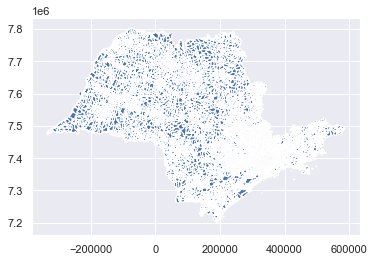

In [51]:
gdf.plot()

<h4>GDF by tracts, RMSP</h4>

In [52]:
#clipping the geo dataframe to the Metro Region of SP
listrmsp = rmsp.CD_GEOCODM.to_list()
gdf_rmsp = gdf[gdf['CD_MUN'].isin(listrmsp)]

In [53]:
gdf_rmsp

,CD_SETOR,CD_DIST,CD_MUN,NM_MUN,geometry
3557,350390105000002,350390105,3503901,Arujá,"POLYGON ((365164.286 7412334.372, 365118.286 7..."
3558,350390105000003,350390105,3503901,Arujá,"POLYGON ((365610.151 7412311.349, 365594.640 7..."
3559,350390105000004,350390105,3503901,Arujá,"POLYGON ((365551.152 7412059.348, 365563.152 7..."
3560,350390105000005,350390105,3503901,Arujá,"POLYGON ((365170.663 7411910.772, 365199.154 7..."
3561,350390105000006,350390105,3503901,Arujá,"POLYGON ((365378.932 7411298.396, 365375.682 7..."
...,...,...,...,...,...
99741,355645305000172,355645305,3556453,Vargem Grande Paulista,"POLYGON ((297227.038 7385092.809, 297240.326 7..."
99742,355645305000173,355645305,3556453,Vargem Grande Paulista,"POLYGON ((295604.571 7385406.773, 295595.563 7..."
99743,355645305000174,355645305,3556453,Vargem Grande Paulista,"POLYGON ((295391.137 7384851.021, 295467.583 7..."
99744,355645305000175,355645305,3556453,Vargem Grande Paulista,"POLYGON ((292107.465 7386367.662, 292169.004 7..."


<AxesSubplot:>

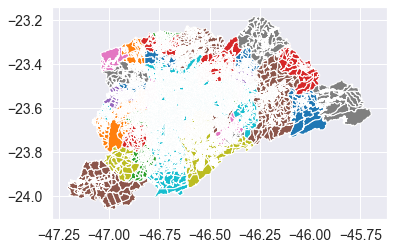

In [148]:
gdf_rmsp.plot('CD_MUN')

<h4>GDF by districts</h4>

In [194]:
IVS_df.columns

Index(['udh', 'nome_udh', 'ivs', 'ivs_infrae', 'ivs_capita', 'ivs_income',
       'idhm', 'idhm_long', 'idhm_educ', 'idhm_income', 'population', 'ring',
       'ibge_code', 'geometry', 'reg'],
      dtype='object')

In [204]:
gdf_dist_mean = IVS_df[:][['ivs', 'ivs_infrae', 'ivs_capita', 'ivs_income',
       'idhm', 'idhm_long', 'idhm_educ', 'idhm_income', 'ring','ibge_code', 'geometry', 'reg']].dissolve(by='ibge_code', aggfunc = 'mean')
gdf_dist_mean.drop(axis=1,columns='geometry',inplace=True)
gdf_dist_sum = IVS_df[:][['ibge_code','geometry','population']].dissolve(by='ibge_code', aggfunc = 'sum')
gdf_dist = gdf_dist_sum.merge(gdf_dist_mean, how="left",on='ibge_code')
gdf_dist['reg'] = gdf_dist['reg'].round(0).astype('int')
gdf_dist

,geometry,population,ivs,ivs_infrae,ivs_capita,ivs_income,idhm,idhm_long,idhm_educ,idhm_income,reg
ibge_code,,,,,,,,,,,
350390105,"POLYGON ((364081.647 7408873.064, 363997.931 7...",74905,0.286235,0.362588,0.271588,0.224882,0.801706,0.867176,0.764294,0.778882,4
350570805,"POLYGON ((308152.557 7398449.846, 308095.414 7...",109576,0.277053,0.328316,0.297947,0.205053,0.790684,0.874737,0.726421,0.779421,3
350570810,"POLYGON ((308056.935 7394227.480, 308037.197 7...",53785,0.303429,0.401714,0.303286,0.205143,0.783714,0.864857,0.746571,0.745571,3
350570815,"POLYGON ((306489.790 7397408.149, 306468.328 7...",27381,0.318000,0.372600,0.327000,0.255400,0.729800,0.827200,0.651600,0.722400,3
350570820,"POLYGON ((307302.731 7395055.193, 307242.447 7...",50007,0.318200,0.401400,0.315200,0.237800,0.749200,0.838400,0.701800,0.716000,3
...,...,...,...,...,...,...,...,...,...,...,...
355250205,"POLYGON ((365665.724 7382064.947, 365648.308 7...",164730,0.325778,0.389630,0.304889,0.282741,0.766815,0.842333,0.741185,0.723000,4
355250210,"POLYGON ((367289.020 7398315.620, 367247.013 7...",82602,0.388909,0.424636,0.392000,0.349818,0.701727,0.793545,0.662727,0.657727,4
355250215,"MULTIPOLYGON (((371708.143 7381763.008, 371646...",15148,0.374625,0.427375,0.372500,0.323875,0.718250,0.807125,0.685875,0.669500,4


In [ ]:
gdf_dist.plot("CD_DIST")

<h4>GDF by districts, RMSP</h4>

In [189]:
gdf_dist_rmsp = gdf_dist[gdf_dist['CD_MUN'].isin(listrmsp)]
#gdf_dist_rmsp.plot('CD_DIST') 
gdf_dist_rmsp

,CD_DIST,geometry,CD_SETOR,CD_MUN,NM_MUN
61,350390105,"POLYGON ((361315.872 7407993.599, 361314.232 7...",350390105000002,3503901,Arujá
84,350570805,"POLYGON ((307173.584 7398612.458, 307163.814 7...",350570805000001,3505708,Barueri
85,350570810,"POLYGON ((308031.209 7394195.680, 308019.371 7...",350570810000004,3505708,Barueri
86,350570815,"POLYGON ((305662.082 7397690.730, 305633.553 7...",350570815000001,3505708,Barueri
87,350570820,"POLYGON ((307212.425 7394171.444, 307189.247 7...",350570820000001,3505708,Barueri
...,...,...,...,...,...
957,355250205,"POLYGON ((363324.667 7382852.886, 363307.232 7...",355250205000002,3552502,Suzano
958,355250210,"POLYGON ((365334.495 7399429.676, 365336.375 7...",355250210000001,3552502,Suzano
959,355250215,"POLYGON ((368829.439 7378712.440, 368793.022 7...",355250215000004,3552502,Suzano
964,355280905,"POLYGON ((315921.973 7384199.190, 315921.547 7...",355280905000002,3552809,Taboão da Serra


In [206]:
#exporting the dataset as Geopackage
gdf_dist_rmsp.to_file('../GIS/CVGI_RMSP census districts IVS_2019 A.gpkg', driver="GPKG")

In [205]:
gdf_rmsp.crs

<Derived Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [150]:
#getting the shapefile, because we can.
#gdf_rsmp.to_file("./GIS/CVGI_SP_census tracts RMSP_2019 A.shp", crs='EPSG:4674')

<h2>Merging geo + cases/deaths</h2>

<h3>Tracts per week</h3>

In [54]:
cases_week_tract.columns

Index(['end_epi_week', 'setorCensitario', 'acc_deaths', 'covid', 'death',
       'sexo', 'racaCor', 'etnia'],
      dtype='object')

In [55]:
cases_week_tract.head()

,end_epi_week,setorCensitario,acc_deaths,covid,death,sexo,racaCor,etnia
0,2020.01,355030801000094,0,1,0,1,1,0
1,2020.01,355030802000047,0,1,0,1,1,0
2,2020.01,355030804000067,0,0,0,1,1,0
3,2020.01,355030804000113,0,1,0,1,1,0
4,2020.01,355030805000070,0,1,0,1,1,0


In [56]:
gdf_rmsp.head()

,CD_SETOR,CD_DIST,CD_MUN,NM_MUN,geometry
3557,350390105000002,350390105,3503901,Arujá,"POLYGON ((365164.286 7412334.372, 365118.286 7..."
3558,350390105000003,350390105,3503901,Arujá,"POLYGON ((365610.151 7412311.349, 365594.640 7..."
3559,350390105000004,350390105,3503901,Arujá,"POLYGON ((365551.152 7412059.348, 365563.152 7..."
3560,350390105000005,350390105,3503901,Arujá,"POLYGON ((365170.663 7411910.772, 365199.154 7..."
3561,350390105000006,350390105,3503901,Arujá,"POLYGON ((365378.932 7411298.396, 365375.682 7..."


In [241]:
gdf_rmsp_cases = gdf_rmsp.merge(cases_week_tract, how='left', left_on=['CD_SETOR'], right_on=['setorCensitario'])
print('Original cases DB:',len(cases_week_tract),'Original GDF:',len(gdf),'Final merged DB:', len(gdf_rmsp_cases))

Original cases DB: 1821434 Original GDF: 100653 Final merged DB: 1295619


In [242]:
gdf_rmsp_cases.head()

,CD_SETOR,CD_DIST,CD_MUN,NM_MUN,geometry,setorCensitario,end_epi_week,covid,death,sexo,racaCor,etnia,acc_deaths
0,350390105000002,350390105,3503901,Arujá,"POLYGON ((365164.286 7412334.372, 365118.286 7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,350390105000003,350390105,3503901,Arujá,"POLYGON ((365610.151 7412311.349, 365594.640 7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,350390105000004,350390105,3503901,Arujá,"POLYGON ((365551.152 7412059.348, 365563.152 7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,350390105000005,350390105,3503901,Arujá,"POLYGON ((365170.663 7411910.772, 365199.154 7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,350390105000006,350390105,3503901,Arujá,"POLYGON ((365378.932 7411298.396, 365375.682 7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
gdf_rmsp_cases.drop(axis=1, columns=['CD_MUN','NM_MUN'], inplace=True) #,'centroid'
#gdf_rmsp_cases.fillna(axis=0,subset=['end_epi_week'],how="all",inplace=True)
gdf_rmsp_cases.dropna(axis=0,subset=['end_epi_week','covid'],how="all",inplace=True)
gdf_rmsp_cases

,CD_SETOR,CD_DIST,geometry,setorCensitario,end_epi_week,covid,death,sexo,racaCor,etnia,acc_deaths
17812,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.01,0.0,0.0,0.0,0.0,0.0,0.0
17813,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.02,0.0,0.0,0.0,0.0,0.0,0.0
17814,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.03,0.0,0.0,0.0,0.0,0.0,0.0
17815,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.04,0.0,0.0,0.0,0.0,0.0,0.0
17816,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.05,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1294164,355030896000247,355030896,"POLYGON ((357499.038 7395275.985, 357481.817 7...",355030896000247,2021.44,0.0,0.0,1.0,1.0,0.0,0.0
1294165,355030896000247,355030896,"POLYGON ((357499.038 7395275.985, 357481.817 7...",355030896000247,2021.45,2.0,0.0,2.0,2.0,0.0,0.0
1294166,355030896000247,355030896,"POLYGON ((357499.038 7395275.985, 357481.817 7...",355030896000247,2021.46,0.0,0.0,2.0,2.0,0.0,0.0
1294167,355030896000247,355030896,"POLYGON ((357499.038 7395275.985, 357481.817 7...",355030896000247,2021.47,0.0,0.0,2.0,2.0,0.0,0.0


In [244]:
gdf_rmsp_cases['epi_week_date'] = ".0"
gdf_rmsp_cases['epi_week_date'] = gdf_rmsp_cases.end_epi_week.astype("str").
str.pad(7, side='right', fillchar='0') + gdf_rmsp_cases.epi_week_date
gdf_rmsp_cases['epi_week_date'] = pd.to_datetime(gdf_rmsp_cases['epi_week_date'],format='%Y.%W.%w')
gdf_rmsp_cases

,CD_SETOR,CD_DIST,geometry,setorCensitario,end_epi_week,covid,death,sexo,racaCor,etnia,acc_deaths,epi_week_date
17812,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12
17813,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.02,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-19
17814,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.03,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-26
17815,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.04,0.0,0.0,0.0,0.0,0.0,0.0,2020-02-02
17816,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.05,0.0,0.0,0.0,0.0,0.0,0.0,2020-02-09
...,...,...,...,...,...,...,...,...,...,...,...,...
1294164,355030896000247,355030896,"POLYGON ((357499.038 7395275.985, 357481.817 7...",355030896000247,2021.44,0.0,0.0,1.0,1.0,0.0,0.0,2021-11-07
1294165,355030896000247,355030896,"POLYGON ((357499.038 7395275.985, 357481.817 7...",355030896000247,2021.45,2.0,0.0,2.0,2.0,0.0,0.0,2021-11-14
1294166,355030896000247,355030896,"POLYGON ((357499.038 7395275.985, 357481.817 7...",355030896000247,2021.46,0.0,0.0,2.0,2.0,0.0,0.0,2021-11-21
1294167,355030896000247,355030896,"POLYGON ((357499.038 7395275.985, 357481.817 7...",355030896000247,2021.47,0.0,0.0,2.0,2.0,0.0,0.0,2021-11-28


In [245]:
gdf_rmsp_cases_export = gdf_rmsp_cases[:][['CD_SETOR', 'CD_DIST', 'geometry',
                                           'setorCensitario', 'end_epi_week',
                                           'covid', 'death','acc_deaths','epi_week_date']]
gdf_rmsp_cases_export

,CD_SETOR,CD_DIST,geometry,setorCensitario,end_epi_week,covid,death,acc_deaths,epi_week_date
17812,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.01,0.0,0.0,0.0,2020-01-12
17813,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.02,0.0,0.0,0.0,2020-01-19
17814,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.03,0.0,0.0,0.0,2020-01-26
17815,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.04,0.0,0.0,0.0,2020-02-02
17816,355030801000001,355030801,"POLYGON ((339819.409 7392592.743, 339756.895 7...",355030801000001,2020.05,0.0,0.0,0.0,2020-02-09
...,...,...,...,...,...,...,...,...,...
1294164,355030896000247,355030896,"POLYGON ((357499.038 7395275.985, 357481.817 7...",355030896000247,2021.44,0.0,0.0,0.0,2021-11-07
1294165,355030896000247,355030896,"POLYGON ((357499.038 7395275.985, 357481.817 7...",355030896000247,2021.45,2.0,0.0,0.0,2021-11-14
1294166,355030896000247,355030896,"POLYGON ((357499.038 7395275.985, 357481.817 7...",355030896000247,2021.46,0.0,0.0,0.0,2021-11-21
1294167,355030896000247,355030896,"POLYGON ((357499.038 7395275.985, 357481.817 7...",355030896000247,2021.47,0.0,0.0,0.0,2021-11-28


In [128]:
%%time
#exporting the dataset as Geopackage
gdf_rmsp_cases_export.to_file('./OUT/CVGI_SP ESUS cases deaths_census tracts_weeks_2020-2021 A.gpkg', 
                              driver="GPKG")

CPU times: user 4min 26s, sys: 8.07 s, total: 4min 34s
Wall time: 4min 41s


In [64]:
gdf_rmsp_cases.acc_deaths.describe()

count    422401.000000
mean          0.144294
std           0.433459
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: acc_deaths, dtype: float64

<AxesSubplot:>

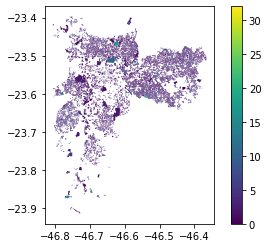

In [573]:
gdf_rmsp_cases[gdf_rmsp_cases.epi_week_date == '2021-09-26'].plot('covid', legend=True)

<h3>Districts per week</h3>

In [152]:
gdf_districts_rmsp.head()

,CD_DIST,CD_SETOR,CD_MUN,NM_MUN,geometry
0,350390105,350390105000002,3503901,Arujá,"POLYGON ((-46.35753 -23.43209, -46.35755 -23.4..."
1,350570805,350570805000001,3505708,Barueri,"POLYGON ((-46.88853 -23.51127, -46.88862 -23.5..."
2,350570810,350570810000004,3505708,Barueri,"POLYGON ((-46.88070 -23.55125, -46.88082 -23.5..."
3,350570815,350570815000001,3505708,Barueri,"POLYGON ((-46.90344 -23.51941, -46.90372 -23.5..."
4,350570820,350570820000001,3505708,Barueri,"POLYGON ((-46.88872 -23.55137, -46.88895 -23.5..."


In [153]:
cases_week_dist.head()

,end_epi_week,CD_DIST,covid,death,sexo,racaCor,etnia,acc_deaths
0,2020.01,355030801,1,0,1.0,1.0,0.0,0
1,2020.01,355030802,1,0,1.0,1.0,0.0,0
2,2020.01,355030803,0,0,1.0,1.0,0.0,0
3,2020.01,355030804,1,0,2.0,2.0,0.0,0
4,2020.01,355030805,3,0,4.0,4.0,0.0,0


In [219]:
gdf_rmsp_dist_cases = gdf_dist.merge(cases_week_dist, how='left', left_on=['ibge_code'], right_on=['CD_DIST'])
print('Original cases DB:',len(cases_week_tract),'Original GDF:',len(gdf),'Final merged DB:', len(gdf_rmsp_dist_cases))
gdf_rmsp_dist_cases.drop(axis=1, columns=['CD_DIST'], inplace=True)#'NM_MUN','CD_SETOR',CD_MUN
na_values = {'end_epi_week':'2020.01','covid':0,'death':0,'sexo':0,'racaCor':0,'etnia':0,'acc_deaths':0}
gdf_rmsp_dist_cases.fillna(value=na_values,inplace=True)
gdf_rmsp_dist_cases['epi_week_date'] = ".0"
gdf_rmsp_dist_cases['epi_week_date'] = gdf_rmsp_dist_cases.end_epi_week.astype("str").str.pad(7, side='right', fillchar='0') + gdf_rmsp_dist_cases.epi_week_date
gdf_rmsp_dist_cases['epi_week_date'] = pd.to_datetime(gdf_rmsp_dist_cases['epi_week_date'],format='%Y.%W.%w')
gdf_rmsp_dist_cases['death_rate'] = gdf_rmsp_dist_cases['acc_deaths'] / (gdf_rmsp_dist_cases['population']/100000)
gdf_rmsp_dist_cases

Original cases DB: 1821434 Original GDF: 100653 Final merged DB: 9761


,geometry,population,ivs,ivs_infrae,ivs_capita,ivs_income,idhm,idhm_long,idhm_educ,idhm_income,reg,end_epi_week,covid,death,sexo,racaCor,etnia,acc_deaths,epi_week_date,death_rate
0,"POLYGON ((364081.647 7408873.064, 363997.931 7...",74905,0.286235,0.362588,0.271588,0.224882,0.801706,0.867176,0.764294,0.778882,4,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
1,"POLYGON ((308152.557 7398449.846, 308095.414 7...",109576,0.277053,0.328316,0.297947,0.205053,0.790684,0.874737,0.726421,0.779421,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
2,"POLYGON ((308056.935 7394227.480, 308037.197 7...",53785,0.303429,0.401714,0.303286,0.205143,0.783714,0.864857,0.746571,0.745571,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
3,"POLYGON ((306489.790 7397408.149, 306468.328 7...",27381,0.318000,0.372600,0.327000,0.255400,0.729800,0.827200,0.651600,0.722400,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
4,"POLYGON ((307302.731 7395055.193, 307242.447 7...",50007,0.318200,0.401400,0.315200,0.237800,0.749200,0.838400,0.701800,0.716000,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,"POLYGON ((365665.724 7382064.947, 365648.308 7...",164730,0.325778,0.389630,0.304889,0.282741,0.766815,0.842333,0.741185,0.723000,4,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
9757,"POLYGON ((367289.020 7398315.620, 367247.013 7...",82602,0.388909,0.424636,0.392000,0.349818,0.701727,0.793545,0.662727,0.657727,4,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
9758,"MULTIPOLYGON (((371708.143 7381763.008, 371646...",15148,0.374625,0.427375,0.372500,0.323875,0.718250,0.807125,0.685875,0.669500,4,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
9759,"POLYGON ((317636.869 7384396.145, 317622.802 7...",313217,0.304971,0.402441,0.303941,0.208853,0.762441,0.850000,0.715118,0.730412,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0


In [220]:
gdf_rmsp_dist_cases['death_rate'].describe()

count    9761.000000
mean       10.466283
std        14.958636
min         0.000000
25%         0.594103
50%         5.038767
75%        13.905305
max        97.409374
Name: death_rate, dtype: float64

<AxesSubplot:>

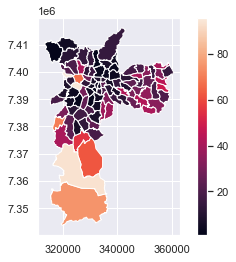

In [222]:
gdf_rmsp_dist_cases[gdf_rmsp_dist_cases.epi_week_date == '2021-09-26'].plot('death_rate', legend=True)

In [223]:
%%time
#exporting the dataset as Geopackage
gdf_rmsp_dist_cases.to_file('./OUT/CVGI_SP ESUS cases deaths_census districts_weeks_2020-2021 A.gpkg', driver="GPKG")

CPU times: user 12.3 s, sys: 577 ms, total: 12.9 s
Wall time: 13.6 s


<h3>Cases per duration and tract</h3>

In [555]:
gdf_rmsp_cases_dur = gdf_rmsp.merge(cases_duration_tract, how='left', left_on=['CD_SETOR'], right_on=['setorCensitario'])
print('Original cases DB:',len(cases_duration_tract),'Original GDF:',len(gdf),'Final merged DB:', len(gdf_rmsp_cases_dur))

Original cases DB: 983221 Original GDF: 100653 Final merged DB: 632166


<AxesSubplot:>

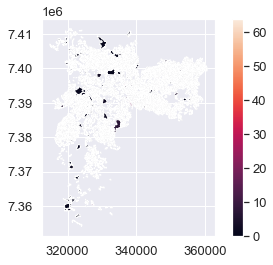

In [559]:
gdf_rmsp_cases_dur[gdf_rmsp_cases_dur.duration == 0].plot('covid', legend=True)

<h3>Using the rings info</h3>

In [171]:
gdf_rings

,CD_SETOR,CD_MUN,NM_MUN,rg_Name,geometry
0,350390105000002,3503901,Arujá,outer metro,"POLYGON ((-46.31948 -23.39321, -46.31993 -23.3..."
1,350390105000003,3503901,Arujá,outer metro,"POLYGON ((-46.31512 -23.39345, -46.31527 -23.3..."
2,350390105000004,3503901,Arujá,outer metro,"POLYGON ((-46.31572 -23.39573, -46.31560 -23.3..."
3,350390105000005,3503901,Arujá,outer metro,"POLYGON ((-46.31946 -23.39704, -46.31918 -23.3..."
4,350390105000006,3503901,Arujá,outer metro,"POLYGON ((-46.31747 -23.40258, -46.31750 -23.4..."
...,...,...,...,...,...
46314,355645305000172,3556453,Vargem Grande Paulista,outer metro,"POLYGON ((-46.98773 -23.63211, -46.98761 -23.6..."
46315,355645305000173,3556453,Vargem Grande Paulista,outer metro,"POLYGON ((-47.00359 -23.62907, -47.00368 -23.6..."
46316,355645305000174,3556453,Vargem Grande Paulista,outer metro,"POLYGON ((-47.00576 -23.63406, -47.00501 -23.6..."
46317,355645305000175,3556453,Vargem Grande Paulista,outer metro,"POLYGON ((-47.03772 -23.61995, -47.03712 -23.6..."


In [251]:
gdf_rings_cases = gdf_rings.merge(cases_week_tract, how='left', left_on=['CD_SETOR'], right_on=['setorCensitario'])
print('Original cases DB:',len(cases_week_tract),'Original GDF:',len(gdf_rings),'Final merged DB:', len(gdf_rings_cases))
gdf_rings_cases.drop(axis=1, columns=['CD_MUN','NM_MUN','setorCensitario'], inplace=True)
gdf_rings_cases.dropna(axis=0,subset=['end_epi_week','covid'],how="all",inplace=True)
#gdf_rings_cases.columns = ['ibge_code', 'ring', 'geometry', 'end_epi_week', 'new_cases', 'new_deaths', 'gender','race', 'ethnicity']

gdf_rings_cases['epi_week_date'] = ".0"
gdf_rings_cases['epi_week_date'] = gdf_rings_cases.end_epi_week.astype("str").str.pad(7, side='right', fillchar='0') + gdf_rings_cases.epi_week_date
gdf_rings_cases['epi_week_date'] = pd.to_datetime(gdf_rings_cases['epi_week_date'],format='%Y.%W.%w')
gdf_rings_cases['new_deaths'] = gdf_rings_cases['new_deaths'].astype('int')
gdf_rings_cases['new_cases'] = gdf_rings_cases['new_cases'].astype('int')
gdf_rings_cases


Original cases DB: 1821434 Original GDF: 46319 Final merged DB: 1295619


KeyError: 'new_deaths'

<h4>optional: dissolving by week and ring</h4>

In [ ]:
dissolved = gdf_rings_cases.dissolve(by=['epi_week_date', 'ring'], aggfunc='sum').reset_index()
dissolved[dissolved.epi_week_date == '2021-09-26'].plot('new_cases', legend=True)

<h1>Analysis</h1>

<h2>Survival analysis: KME by ring</h2>

<h3>defs</h3>

In [41]:
def events_cities(cases):
    start_time = time.time()
    total_deaths = 0
    for id_wk, val_wk in enumerate(cases.epi_week):
        #check if there are any cases, otherwise skip
        var_deaths = cases[(cases.epi_week == val_wk)].new_deaths.tolist()[0]
        #check if the death number of a city is positive. we are ignoring the negative numbers.
        if var_deaths > 0: total_deaths = total_deaths + var_deaths
    events = pd.DataFrame({'event': pd.Series([], dtype='int'),'week':pd.Series([], dtype='int')}, 
                          index=range(total_deaths))
    c = 0
    for id_wk, val_wk in enumerate(cases.epi_week):
        #check if there are any cases, otherwise skip
        var_deaths = cases[(cases.epi_week == val_wk)].new_deaths.tolist()[0]
        #ignore negative death numbers (they are low, and apply to very few cases, see if this needs to be improved)
        if var_deaths > 0:
            for i in range(var_deaths):
                events['event'].iloc[c] = 1 
                events['week'].iloc[c] = id_wk
                c = c + 1
    t1 = "--- %s seconds ---" % (time.time() - start_time)
    return events

#this function takes four parameters: a list of city codes, a cut date (after which data is not used), the time step variable, and the events variable
def events_mc(df, cities_list, dates=None, var_time='epi_week', var_events='new_deaths'):
    #cases_uf = cases[(cases['ibge_code'].str.startswith(uf)) & (cases['epi_week_date'] < ('2021-02-25'))]
    df_cases = df
    unique_cities = cities_list
    dict_events_mc = {}
    
    if dates == None:
        for ibge_code in unique_cities:
            #print(ibge_code)
            cases_test = df_cases[df_cases.ibge_code == ibge_code][['epi_week','new_deaths']]
            dict_events_mc[ibge_code] = events_cities(cases_test)
    #function returns a dict, it can be transformed in a dataframe using concat
    else:
        for ibge_code in unique_cities:
            #print(ibge_code)
            cases_test = df_cases[(df_cases.ibge_code == ibge_code)&(df_cases.epi_week_date < dates)][['epi_week','new_deaths']]
            dict_events_mc[ibge_code] = events_cities(cases_test)
    df_events = pd.concat(dict_events_mc)
    return df_events

<h3>Data preparation</h3>

<h4>Preparing lists of census tracts to pass to KME</h4>

In [167]:
gdf_rmsp_dist_cases.columns

Index(['CD_DIST', 'geometry', 'end_epi_week', 'covid', 'death', 'sexo',
       'racaCor', 'etnia', 'acc_deaths', 'epi_week_date'],
      dtype='object')

In [168]:
gdf_rmsp_dist_cases.columns = ['ibge_code', 'geometry', 'epi_week', 'new_cases', 'new_deaths',  'gender','race', 'ethnicity','acc_deaths', 'epi_week_date']
gdf_rmsp_dist_cases['new_deaths'] = gdf_rmsp_dist_cases['new_deaths'].astype('int')
gdf_rmsp_dist_cases['new_cases'] = gdf_rmsp_dist_cases['new_cases'].astype('int')

In [249]:
gdf_rmsp_dist_cases

,geometry,population,ivs,ivs_infrae,ivs_capita,ivs_income,idhm,idhm_long,idhm_educ,idhm_income,reg,end_epi_week,covid,death,sexo,racaCor,etnia,acc_deaths,epi_week_date,death_rate
0,"POLYGON ((364081.647 7408873.064, 363997.931 7...",74905,0.286235,0.362588,0.271588,0.224882,0.801706,0.867176,0.764294,0.778882,4,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
1,"POLYGON ((308152.557 7398449.846, 308095.414 7...",109576,0.277053,0.328316,0.297947,0.205053,0.790684,0.874737,0.726421,0.779421,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
2,"POLYGON ((308056.935 7394227.480, 308037.197 7...",53785,0.303429,0.401714,0.303286,0.205143,0.783714,0.864857,0.746571,0.745571,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
3,"POLYGON ((306489.790 7397408.149, 306468.328 7...",27381,0.318000,0.372600,0.327000,0.255400,0.729800,0.827200,0.651600,0.722400,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
4,"POLYGON ((307302.731 7395055.193, 307242.447 7...",50007,0.318200,0.401400,0.315200,0.237800,0.749200,0.838400,0.701800,0.716000,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,"POLYGON ((365665.724 7382064.947, 365648.308 7...",164730,0.325778,0.389630,0.304889,0.282741,0.766815,0.842333,0.741185,0.723000,4,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
9757,"POLYGON ((367289.020 7398315.620, 367247.013 7...",82602,0.388909,0.424636,0.392000,0.349818,0.701727,0.793545,0.662727,0.657727,4,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
9758,"MULTIPOLYGON (((371708.143 7381763.008, 371646...",15148,0.374625,0.427375,0.372500,0.323875,0.718250,0.807125,0.685875,0.669500,4,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
9759,"POLYGON ((317636.869 7384396.145, 317622.802 7...",313217,0.304971,0.402441,0.303941,0.208853,0.762441,0.850000,0.715118,0.730412,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0


In [248]:
gdf_rmsp_dist_cases

,geometry,population,ivs,ivs_infrae,ivs_capita,ivs_income,idhm,idhm_long,idhm_educ,idhm_income,reg,end_epi_week,covid,death,sexo,racaCor,etnia,acc_deaths,epi_week_date,death_rate
0,"POLYGON ((364081.647 7408873.064, 363997.931 7...",74905,0.286235,0.362588,0.271588,0.224882,0.801706,0.867176,0.764294,0.778882,4,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
1,"POLYGON ((308152.557 7398449.846, 308095.414 7...",109576,0.277053,0.328316,0.297947,0.205053,0.790684,0.874737,0.726421,0.779421,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
2,"POLYGON ((308056.935 7394227.480, 308037.197 7...",53785,0.303429,0.401714,0.303286,0.205143,0.783714,0.864857,0.746571,0.745571,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
3,"POLYGON ((306489.790 7397408.149, 306468.328 7...",27381,0.318000,0.372600,0.327000,0.255400,0.729800,0.827200,0.651600,0.722400,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
4,"POLYGON ((307302.731 7395055.193, 307242.447 7...",50007,0.318200,0.401400,0.315200,0.237800,0.749200,0.838400,0.701800,0.716000,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,"POLYGON ((365665.724 7382064.947, 365648.308 7...",164730,0.325778,0.389630,0.304889,0.282741,0.766815,0.842333,0.741185,0.723000,4,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
9757,"POLYGON ((367289.020 7398315.620, 367247.013 7...",82602,0.388909,0.424636,0.392000,0.349818,0.701727,0.793545,0.662727,0.657727,4,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
9758,"MULTIPOLYGON (((371708.143 7381763.008, 371646...",15148,0.374625,0.427375,0.372500,0.323875,0.718250,0.807125,0.685875,0.669500,4,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0
9759,"POLYGON ((317636.869 7384396.145, 317622.802 7...",313217,0.304971,0.402441,0.303941,0.208853,0.762441,0.850000,0.715118,0.730412,3,2020.01,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-12,0.0


In [247]:
#tract_list = gdf_rings_cases[gdf_rings_cases.ibge_code == '355030801000001'].ibge_code.tolist() #outer-periphery, inner-periphery, central
dist_list = gdf_rmsp_dist_cases.ibge_code.unique().tolist()
central_list = gdf_rings_cases[gdf_rings_cases.ring == 'central'].ibge_code.tolist() #outer-periphery, inner-periphery, central
inner_list = gdf_rings_cases[gdf_rings_cases.ring == 'inner-periphery'].ibge_code.tolist() #outer-periphery, inner-periphery, central
outer_list = gdf_rings_cases[gdf_rings_cases.ring == 'outer-periphery'].ibge_code.tolist() #outer-periphery, inner-periphery, central

print('central:', len(central_list),'inner:', len(inner_list),'outer:', len(outer_list))

AttributeError: 'GeoDataFrame' object has no attribute 'ibge_code'

<h4>Adding SVI info</h4>

In [332]:
rows = ['central','inner-periphery','outer-periphery','metro-periphery','SP']
cols = ['min','25','50','75','max']
svi_reg = pd.DataFrame(columns=cols,index=rows)
svi_reg

,min,25,50,75,max
central,NaN,NaN,NaN,NaN,NaN
inner-periphery,NaN,NaN,NaN,NaN,NaN
outer-periphery,NaN,NaN,NaN,NaN,NaN
metro-periphery,NaN,NaN,NaN,NaN,NaN
SP,NaN,NaN,NaN,NaN,NaN


In [333]:
#checking each region for its SVI quantiles
df = IVS_df
for i in range(len(svi_reg.index)):
    svi_reg.iloc[i]['min'] = df[df.reg == (i+1)].ivs.min()
    svi_reg.iloc[i]['25'] = df[df.reg == (i+1)].ivs.quantile(q=.25)
    svi_reg.iloc[i]['50'] = df[df.reg == (i+1)].ivs.quantile(q=.50)
    svi_reg.iloc[i]['75'] = df[df.reg == (i+1)].ivs.quantile(q=.75)
    svi_reg.iloc[i]['max'] = df[df.reg == (i+1)].ivs.max()
svi_reg

,min,25,50,75,max
central,0.04,0.137,0.253,0.325,0.498
inner-periphery,0.04,0.244,0.3,0.357,0.499
outer-periphery,0.04,0.29,0.337,0.374,0.505
metro-periphery,0.096,0.278,0.3345,0.37625,0.476
SP,NaN,NaN,NaN,NaN,NaN


In [334]:
df = IVS_df
svi_reg.loc['SP']['min'] = df.ivs.min()
svi_reg.loc['SP']['25'] = df.ivs.quantile(q=.25)
svi_reg.loc['SP']['50'] = df.ivs.quantile(q=.50)
svi_reg.loc['SP']['75'] = df.ivs.quantile(q=.75)
svi_reg.loc['SP']['max'] = df.ivs.max()
svi_reg

,min,25,50,75,max
central,0.04,0.137,0.253,0.325,0.498
inner-periphery,0.04,0.244,0.3,0.357,0.499
outer-periphery,0.04,0.29,0.337,0.374,0.505
metro-periphery,0.096,0.278,0.3345,0.37625,0.476
SP,0.04,0.249,0.313,0.36,0.505


In [335]:
IVS_df.head()

,udh,nome_udh,ivs,ivs_infrae,ivs_capita,ivs_income,idhm,idhm_long,idhm_educ,idhm_income,ring,ibge_code,geometry,reg
0,1.351880e+12,Várzea do Palácio,0.339,0.240,0.442,0.337,0.661,0.760,0.582,0.652,central,351880010,"MULTIPOLYGON (((341738.988 7399577.772, 341750...",1
1,1.351880e+12,Itapegica : Escola Estadual Coronel Ary Gomes ...,0.242,0.355,0.195,0.177,0.831,0.907,0.792,0.798,central,351880005,"MULTIPOLYGON (((342179.361 7400016.536, 342174...",1
2,1.351880e+12,Vila Flora,0.414,0.412,0.466,0.365,0.653,0.742,0.594,0.633,central,351880005,"MULTIPOLYGON (((341116.700 7401331.046, 341109...",1
3,1.351880e+12,Itapegica : Comunidade Saigo,0.416,0.412,0.472,0.365,0.653,0.742,0.594,0.633,central,351880005,"MULTIPOLYGON (((341051.300 7401984.302, 341042...",1
4,1.351880e+12,Itapegica : São Rafael,0.308,0.239,0.419,0.265,0.745,0.830,0.715,0.696,central,351880005,"MULTIPOLYGON (((341250.153 7402601.435, 341236...",1


<h4>Creating events DFs by ring</h4>

In [231]:
dict_reg = {'central':1,'inner-periphery':2,'outer-periphery':3,'metro-periphery':4,'SP':5}

In [232]:
rg = 'central'
svi_central_list = df[(df.reg == dict_reg[rg])].ibge_code.to_list()
print(len(svi_central_list))

633


In [233]:
rg = 'inner-periphery'
svi_inner_list = df[(df.reg == dict_reg[rg])].ibge_code.to_list()
print(len(svi_inner_list))

911


In [234]:
rg = 'outer-periphery'
svi_outer_list = df[(df.reg == dict_reg[rg])].ibge_code.to_list()
print(len(svi_outer_list))

1159


In [235]:
rg = 'metro-periphery'
svi_metro_list = df[(df.reg == dict_reg[rg])].ibge_code.to_list()
print(len(svi_metro_list))

426


In [236]:
%%time
svi_central_df = events_mc(gdf_rmsp_dist_cases,svi_central_list)
svi_inner_df = events_mc(gdf_rmsp_dist_cases,svi_inner_list)
svi_outer_df = events_mc(gdf_rmsp_dist_cases,svi_outer_list)
svi_metro_df = events_mc(gdf_rmsp_dist_cases,svi_metro_list)

AttributeError: 'GeoDataFrame' object has no attribute 'ibge_code'

<h3>KME results</h3>

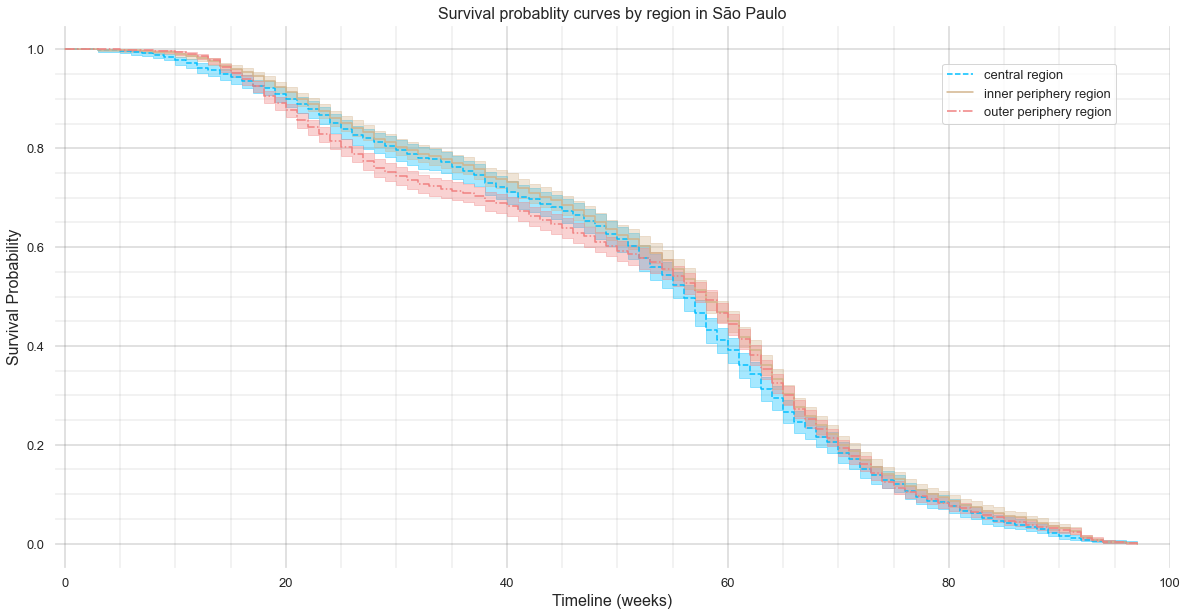

In [518]:
df1 = svi_central_df
df2 = svi_inner_df
df3 = svi_outer_df

save_fig = True
ci_alpha_value = 0.35
lineStyles = ['--','-','-.',':']
cmap = matplotlib.cm.get_cmap('viridis')
color_list = ['deepskyblue','tan','lightcoral','lightsalmon','salmon'] 
#setting font sizes
ss = 13
ms = 16
ls = 18

plt.rc('font', size=ss)          # controls default text sizes
plt.rc('axes', titlesize=ms)     # fontsize of the axes title
plt.rc('axes', labelsize=ms)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=ss)    # fontsize of the tick labels
plt.rc('ytick', labelsize=ss)    # fontsize of the tick labels
plt.rc('legend', fontsize=ss)    # legend fontsize

fig,ax = plt.subplots(figsize=(20,10))#,gridspec_kw=dict(right=0.9)
ax.set_facecolor((1, 1,1))

#fitting the model
kmf_ext1 = KaplanMeierFitter() 
T1 = df1['week']     ## time to event
E1 = df1['event']      ## event occurred or censored
label1 = 'central region'
kmf_ext1.fit(T1, E1, label=label1)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext1.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[0],ls=lineStyles[0])

kmf_ext2 = KaplanMeierFitter() 
T2 = df2['week']     ## time to event
E2 = df2['event']      ## event occurred or censored
label2 = 'inner periphery region'
kmf_ext2.fit(T2, E2, label=label2)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext2.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[1],ls=lineStyles[1]) #show_censors=True

kmf_ext3 = KaplanMeierFitter() 
T3 = df3['week']     ## time to event
E3 = df3['event']      ## event occurred or censored
label3 = 'outer periphery region'
kmf_ext3.fit(T3, E3, label=label3)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext3.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[2],ls=lineStyles[2]) #show_censors=True

plt.minorticks_on()
ax.grid(b=True, which='minor', color='grey', linewidth=0.2)
ax.grid(b=True, which='major', color='dimgrey', linewidth=0.4)
ax.set(title = "Survival probablity curves by region in São Paulo", xlabel='Timeline (weeks)', 
       ylabel='Survival Probability',xlim=[-1,100])#\n
#plt.setp(ax.get_xticklabels(), rotation = 0)

#ax.vlines([90], 0, 1, colors='grey',lw=2, linestyles='--') #, label='scope of KME analysis'
#ax.text(89.7,-0.02,'16.10.2021 \n(scope of analysis)',color='black',ha='center',va='top')
#ax.text(-0.235,-0.06,'(04/01/2020)',color='black')
#ax.text(101,-0.06,'(30/11/2021)',color='black',ha='right')
#for i in range(len(vlines_pos)):
#    ax.text((vlines_pos[i]-0.2),-0.03,vlines_pos_dict[vlines_pos[i]],color='black',ha='center',va='top')  #i+1
#ax.vlines(vlines_pos, 0, 1, colors='grey',lw=1.5, linestyles='-', label='phases of the pandemic')

#fig.suptitle('Survival probablity curves by vulnerability degree')
plt.legend(bbox_to_anchor=(0.79, 0.94), loc='upper left', facecolor='white') #legend comes last to catch all elements from plot and phases of the pandemic

if save_fig == True:
    file_name = 'CVGI_KME_SVI_districts_per_ring_D5.png'
    file_path = Path('./OUT/')
    url = file_path / file_name
    plt.savefig(url, dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()

<h4>Adjusting the events coding function</h4>

In [409]:
def events_cities_2(cases):
    start_time = time.time()
    total_deaths = 0
    for id_wk, val_wk in enumerate(cases.epi_week):
        if id_wk == 0: first_wk = val_wk
        #check if there are any events, otherwise skip
        var_deaths = cases[(cases.epi_week == val_wk)].new_deaths.tolist()[0]
        #check if the death number of a city is positive. we are ignoring the negative numbers.
        if var_deaths > 0: total_deaths = total_deaths + var_deaths
    events = pd.DataFrame({'event': pd.Series([], dtype='int'),
                           'week':pd.Series([], dtype='int'),'week_val':pd.Series([], dtype='str')}, index=range(total_deaths))
    c = 0
    for id_wk, val_wk in enumerate(cases.epi_week):
        #check if there are any cases, otherwise skip
        var_deaths = cases[(cases.epi_week == val_wk)].new_deaths.tolist()[0]
        #ignore negative death numbers (they are low, and apply to very few cases, see if this needs to be improved)
        if var_deaths > 0:
            for i in range(var_deaths):
                events.iloc[c,events.columns.get_loc('event')] = 1 
                events.iloc[c,events.columns.get_loc('week')] = id_wk
                events.iloc[c,events.columns.get_loc('week_val')] = val_wk
                c = c + 1
    t1 = "--- %s seconds ---" % (time.time() - start_time)
    return events

<h3>Cox proportional risk model by rings</h3>

<h4>preparing the data</h4>

In [229]:
svi_central_df
svi_inner_df
svi_outer_df
svi_metro_df

NameError: name 'svi_central_df' is not defined

In [347]:
cox_central = svi_central_df.reset_index()[:][['level_0','event','week']]
cox_central['ring'] = 1
cox_central.drop(axis=1,columns=['level_0'], inplace=True)
cox_central

,event,week,ring
0,1.0,19.0,1
1,1.0,19.0,1
2,1.0,20.0,1
3,1.0,20.0,1
4,1.0,24.0,1
...,...,...,...
1377,1.0,92.0,1
1378,1.0,93.0,1
1379,1.0,94.0,1
1380,1.0,97.0,1


In [348]:
cox_inner = svi_inner_df.reset_index()[:][['level_0','event','week']]
cox_inner['ring'] = 2
cox_inner.drop(axis=1,columns=['level_0'], inplace=True)
cox_inner

,event,week,ring
0,1.0,10.0,2
1,1.0,14.0,2
2,1.0,19.0,2
3,1.0,20.0,2
4,1.0,29.0,2
...,...,...,...
2152,1.0,93.0,2
2153,1.0,93.0,2
2154,1.0,93.0,2
2155,1.0,93.0,2


In [349]:
cox_outer = svi_outer_df.reset_index()[:][['level_0','event','week']]
cox_outer['ring'] = 3
cox_outer.drop(axis=1,columns=['level_0'], inplace=True)
cox_outer

,event,week,ring
0,1.0,9.0,3
1,1.0,18.0,3
2,1.0,49.0,3
3,1.0,52.0,3
4,1.0,56.0,3
...,...,...,...
2246,1.0,93.0,3
2247,1.0,93.0,3
2248,1.0,93.0,3
2249,1.0,93.0,3


<h4>generating dummies</h4>

In [350]:
cox_rings = pd.concat([cox_central,cox_inner,cox_outer])
cox_dummies = pd.get_dummies(cox_rings, drop_first=True)
cox_dummies

,event,week,ring
0,1.0,19.0,1
1,1.0,19.0,1
2,1.0,20.0,1
3,1.0,20.0,1
4,1.0,24.0,1
...,...,...,...
2246,1.0,93.0,3
2247,1.0,93.0,3
2248,1.0,93.0,3
2249,1.0,93.0,3


<h4>fitting</h4>

<lifelines.CoxPHFitter: fitted with 5790 total observations, 0 right-censored observations>
             duration col = 'week'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 5790
number of events observed = 5790
   partial log-likelihood = -44378.89
         time fit was run = 2022-10-26 18:04:47 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
ring       -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02

            cmp to     z    p   -log2(p)
covariate                               
ring          0.00 -0.73 0.47       1.10
---
Concordance = 0.51
Partial AIC = 88759.79
log-likelihood ratio test = 0.53 on 1 df
-log2(p) of ll-ratio test = 1.10

<AxesSubplot:xlabel='log(HR) (95% CI)'>

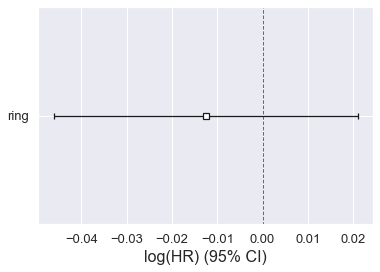

In [520]:
#After creating the dummies, we implement the model:
from lifelines import CoxPHFitter
cph = CoxPHFitter()   ## Instantiate the class to create a cph object

#We pass three parameters to the model: the dataset (df_dummy), the time column (tenure), and the event column (Churn).
df = cox_dummies

cph.fit(df, duration_col='week', event_col='event')   ## Fit the data to train the model #,cluster_col='ring'

#The summary presents the statistics
cph.print_summary()

cph.plot()

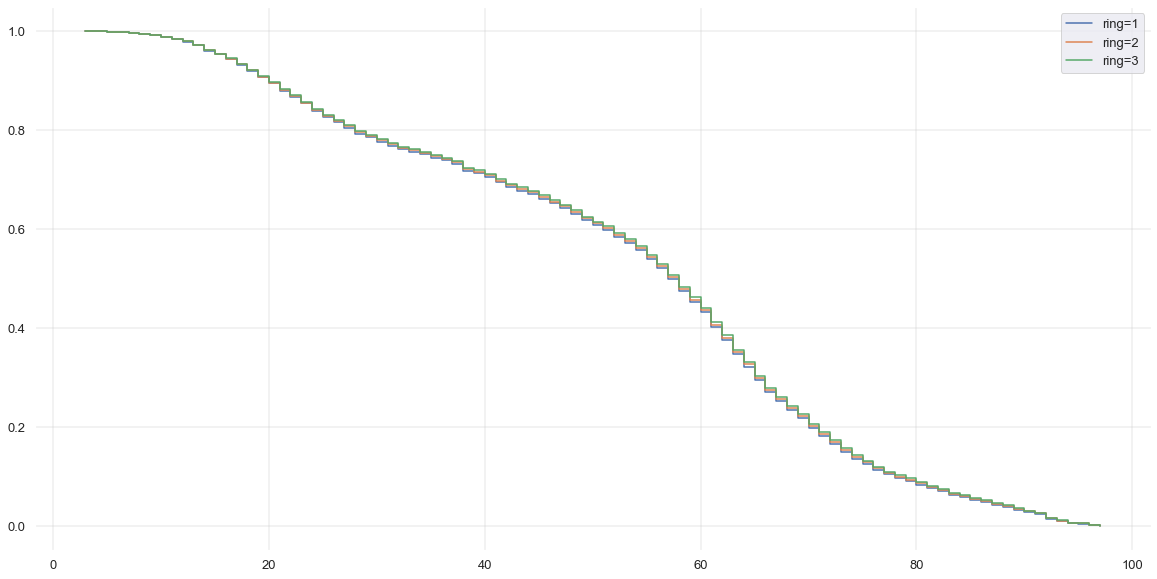

In [522]:
fig,ax = plt.subplots(figsize=(20,10))
ax.set_facecolor((1, 1,1))
cph.plot_partial_effects_on_outcome(covariates=["ring"],values=[1, 2, 3],plot_baseline=False, ax=ax)
ax.grid(b=True, which='minor', color='silver', linewidth=0.4)
ax.grid(b=True, which='major', color='silver', linewidth=0.4)
plt.show()


In [460]:
cox_dummies

,event,week,ring
0,1.0,9.0,1
1,1.0,9.0,1
2,1.0,11.0,1
3,1.0,11.0,1
4,1.0,12.0,1
...,...,...,...
2252,1.0,75.0,3
2253,1.0,76.0,3
2254,1.0,77.0,3
2255,1.0,77.0,3


In [464]:
from lifelines.statistics import multivariate_logrank_test
duration = cox_dummies['week']
groups = cox_dummies['ring']
events = cox_dummies['event']
results = multivariate_logrank_test(duration, groups, events)
results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           9.55 0.01      6.89

<h3>Creating events dfs by region and IVS</h3>

In [227]:
dict_reg = {'central':1,'inner-periphery':2,'outer-periphery':3,'metro-periphery':4,'SP':5}
def svi_lists(rg, reg_75_max, reg__75_50, reg__50_25, reg_25_min,df = IVS_df):  
    #print(df[(df.reg == dict_reg[rg])])
    reg_75_max = df[(df.reg == dict_reg[rg]) & (df.ivs >= svi_reg.loc[rg]['75'])].ibge_code.to_list()
    reg__75_50 = df[(df.reg == dict_reg[rg]) & (df.ivs < svi_reg.loc[rg]['75']) & (df.ivs >= svi_reg.loc[rg]['50'])].ibge_code.to_list()
    reg__50_25 = df[(df.reg == dict_reg[rg]) & (df.ivs < svi_reg.loc[rg]['50']) & (df.ivs >= svi_reg.loc[rg]['25'])].ibge_code.to_list()
    reg_25_min = df[(df.reg == dict_reg[rg]) & (df.ivs < svi_reg.loc[rg]['25'])].ibge_code.to_list()
    print(len(reg_75_max), len(reg__75_50), len(reg__50_25), len(reg_25_min))
    return reg_75_max, reg__75_50, reg__50_25, reg_25_min

# I could probably add a dictionary here to call the n of each list later

In [228]:
reg = 'central'
svi_cen_75_max_list, svi_cen_75_50_list, svi_cen_50_25_list, svi_cen_25_min_list = svi_lists(reg,'central_75_max', 'central_75_50', 'central_50_25', 'central_25_min',IVS_df)

NameError: name 'svi_reg' is not defined

In [308]:
reg = 'inner-periphery'
svi_inner_75_max_list, svi_inner_75_50_list, svi_inner_50_25_list, svi_inner_25_min_list = svi_lists(reg,'inner_75_max', 'inner_75_50', 'inner_50_25', 'inner_25_min',IVS_df)

229 227 230 225


In [309]:
reg = 'outer-periphery'
svi_outer_75_max_list, svi_outer_75_50_list, svi_outer_50_25_list, svi_outer_25_min_list = svi_lists(reg,'outer_75_max', 'outer_75_50', 'outer_50_25', 'outer_25_min',IVS_df)

291 290 291 287


In [310]:
reg = 'metro-periphery'
svi_metro_75_max_list, svi_metro_75_50_list, svi_metro_50_25_list, svi_metro_25_min_list = svi_lists(reg,'metro_75_max', 'metro_75_50', 'metro_50_25', 'metro_25_min',IVS_df)

107 106 107 106


In [311]:
df = IVS_df
reg = 'SP'

svi_SP_75_max_list = df[df.ivs >= svi_reg.loc[reg]['75']].ibge_code.to_list()
svi_SP_75_50_list = df[(df.ivs < svi_reg.loc[reg]['75']) & (df.ivs >= svi_reg.loc[reg]['50'])].ibge_code.to_list()
svi_SP_50_25_list = df[(df.ivs < svi_reg.loc[reg]['50']) & (df.ivs >= svi_reg.loc[reg]['25'])].ibge_code.to_list()
svi_SP_25_min_list = df[(df.ivs < svi_reg.loc[reg]['25'])].ibge_code.to_list()
print(len(svi_SP_75_max_list), len(svi_SP_75_50_list), len(svi_SP_50_25_list), len(svi_SP_25_min_list))

796 778 780 775


<h4>IVS only for SP </h4>

In [465]:
rows = ['SP']
cols = ['min','33','66','max']
svi_sp = pd.DataFrame(columns=cols,index=rows)
svi_sp


,min,33,66,max
SP,NaN,NaN,NaN,NaN


In [226]:
df = IVS_df
svi_sp.loc['SP']['min'] = df.ivs.min()
svi_sp.loc['SP']['33'] = df.ivs.quantile(q=.33)
svi_sp.loc['SP']['66'] = df.ivs.quantile(q=.66)
svi_sp.loc['SP']['max'] = df.ivs.max()
svi_sp

NameError: name 'svi_sp' is not defined

In [225]:
df = IVS_df
reg = 'SP'

svi_SP_66_max_list = df[df.ivs >= svi_sp.loc[reg]['66']].ibge_code.to_list()
svi_SP_66_33_list = df[(df.ivs < svi_sp.loc[reg]['66']) & (df.ivs >= svi_sp.loc[reg]['33'])].ibge_code.to_list()
svi_SP_33_min_list = df[(df.ivs < svi_sp.loc[reg]['33'])].ibge_code.to_list()
print(len(svi_SP_66_max_list), len(svi_SP_66_33_list), len(svi_SP_33_min_list))

NameError: name 'svi_sp' is not defined

In [471]:
%%time
svi_SP_66_max_df = events_mc(gdf_rmsp_dist_cases,svi_SP_66_max_list)
svi_SP_66_33_df = events_mc(gdf_rmsp_dist_cases,svi_SP_66_33_list)
svi_SP_33_min_df = events_mc(gdf_rmsp_dist_cases,svi_SP_33_min_list)

CPU times: user 1min 1s, sys: 312 ms, total: 1min 1s
Wall time: 1min 2s


In [224]:
df1 = svi_SP_66_max_df
df2 = svi_SP_66_33_df
df3 = svi_SP_33_min_df

save_fig = False
ci_alpha_value = 0.35
lineStyles = ['--','-','-.',':']
cmap = matplotlib.cm.get_cmap('viridis') # tab10
color_list = ['dodgerblue','lightseagreen','tan','lightsalmon','salmon']
#setting font sizes
ss = 13
ms = 16
ls = 18

plt.rc('font', size=ss)          # controls default text sizes
plt.rc('axes', titlesize=ms)     # fontsize of the axes title
plt.rc('axes', labelsize=ms)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=ss)    # fontsize of the tick labels
plt.rc('ytick', labelsize=ss)    # fontsize of the tick labels
plt.rc('legend', fontsize=ss)    # legend fontsize

fig.suptitle('Survival probablity curves by vulnerability degree')
fig,ax = plt.subplots(figsize=(20,10))#,gridspec_kw=dict(right=0.9)


#for i in range(len(vlines_pos)):
#    text((vlines_pos[i]-0.3),1.01,i+1,color='darkgrey')
#ax.vlines([53], 0, 1, colors='grey',lw=2, linestyles='--') #, label='scope of KME analysis'
ax.set_facecolor((1, 1,1))
vlines_pos = [5,13,21,30,38,53]
ax.vlines(vlines_pos, 0, 1, colors='darkgrey',lw=1.5, linestyles='-', label='phases of the pandemic')

#text(52.7,1.01,'6, (scope of analysis)',color='black')
plt.minorticks_on()
plt.grid(b=True, which='both',color='gainsboro', linestyle='-', linewidth=0.4)

#fitting for allcities at the same time
kmf_ext1 = KaplanMeierFitter() 
T1 = df1['week']     ## time to event
E1 = df1['event']      ## event occurred or censored
label1 = 'from maximum to 66 percentile (n='+str(len(svi_SP_66_max_list))+')'

kmf_ext1.fit(T1, E1, label=label1)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext1.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[0],ls=lineStyles[0])


kmf_ext2 = KaplanMeierFitter() 

T2 = df2['week']     ## time to event
E2 = df2['event']      ## event occurred or censored
label2 = 'from 66 to 33 percentile (n='+str(len(svi_SP_66_33_list))+')'
kmf_ext2.fit(T2, E2, label=label2)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext2.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[1],ls=lineStyles[1]) #show_censors=True

kmf_ext3 = KaplanMeierFitter() 
T3 = df3['week']     ## time to event
E3 = df3['event']      ## event occurred or censored
label3 = 'from 33 percentile  to min (n='+str(len(svi_SP_33_min_list))+')'

kmf_ext3.fit(T3, E3, label=label3)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext3.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[2],ls=lineStyles[2]) #show_censors=True

plt.setp(ax.get_xticklabels(), rotation = 0)
plt.legend(bbox_to_anchor=(0.79, 0.94), loc='upper left', facecolor='white') #
ax.set(title = "Survival probablity curves by region in \n São Paulo", xlabel='Timeline (weeks)', ylabel='Survival Probability',xlim=[-1,90])

if save_fig == True:
    file_name = 'CVGI_KME_SVI_districts_per_SVI_D3.png'
    file_path = Path('./06 imgs/')
    url = file_path / file_name
    plt.savefig(url, dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()

NameError: name 'svi_SP_66_max_df' is not defined

<h4>IVS & rings</h4>

In [315]:
%%time
svi_cen_75_max_df = events_mc(gdf_rmsp_dist_cases,svi_cen_75_max_list)
svi_cen_75_50_df = events_mc(gdf_rmsp_dist_cases,svi_cen_75_50_list)
svi_cen_50_25_df = events_mc(gdf_rmsp_dist_cases,svi_cen_50_25_list)
svi_cen_25_min_df = events_mc(gdf_rmsp_dist_cases,svi_cen_25_min_list)

CPU times: user 17.9 s, sys: 34.2 ms, total: 17.9 s
Wall time: 17.9 s


In [317]:
%%time
svi_inner_75_max_df = events_mc(gdf_rmsp_dist_cases,svi_inner_75_max_list)
svi_inner_75_50_df = events_mc(gdf_rmsp_dist_cases,svi_inner_75_50_list)
svi_inner_50_25_df = events_mc(gdf_rmsp_dist_cases,svi_inner_50_25_list)
svi_inner_25_min_df = events_mc(gdf_rmsp_dist_cases,svi_inner_25_min_list)

CPU times: user 20.7 s, sys: 66 ms, total: 20.7 s
Wall time: 20.7 s


In [321]:
%%time
svi_outer_75_max_df = events_mc(gdf_rmsp_dist_cases,svi_outer_75_max_list)
svi_outer_75_50_df = events_mc(gdf_rmsp_dist_cases,svi_outer_75_50_list)
svi_outer_50_25_df = events_mc(gdf_rmsp_dist_cases,svi_outer_50_25_list)
svi_outer_25_min_df = events_mc(gdf_rmsp_dist_cases,svi_outer_25_min_list)

CPU times: user 19.5 s, sys: 43.6 ms, total: 19.5 s
Wall time: 19.5 s


In [322]:
%%time
svi_metro_75_max_df = events_mc(gdf_rmsp_dist_cases,svi_metro_75_max_list)
svi_metro_75_50_df = events_mc(gdf_rmsp_dist_cases,svi_metro_75_50_list)
svi_metro_50_25_df = events_mc(gdf_rmsp_dist_cases,svi_metro_50_25_list)
svi_metro_25_min_df = events_mc(gdf_rmsp_dist_cases,svi_metro_25_min_list)

CPU times: user 1.66 s, sys: 7.21 ms, total: 1.67 s
Wall time: 1.66 s


In [323]:
%%time
svi_SP_75_max_df = events_mc(gdf_rmsp_dist_cases,svi_SP_75_max_list)
svi_SP_75_50_df = events_mc(gdf_rmsp_dist_cases,svi_SP_75_50_list)
svi_SP_50_25_df = events_mc(gdf_rmsp_dist_cases,svi_SP_50_25_list)
svi_SP_25_min_df = events_mc(gdf_rmsp_dist_cases,svi_SP_25_min_list)

CPU times: user 59.8 s, sys: 106 ms, total: 59.9 s
Wall time: 59.9 s


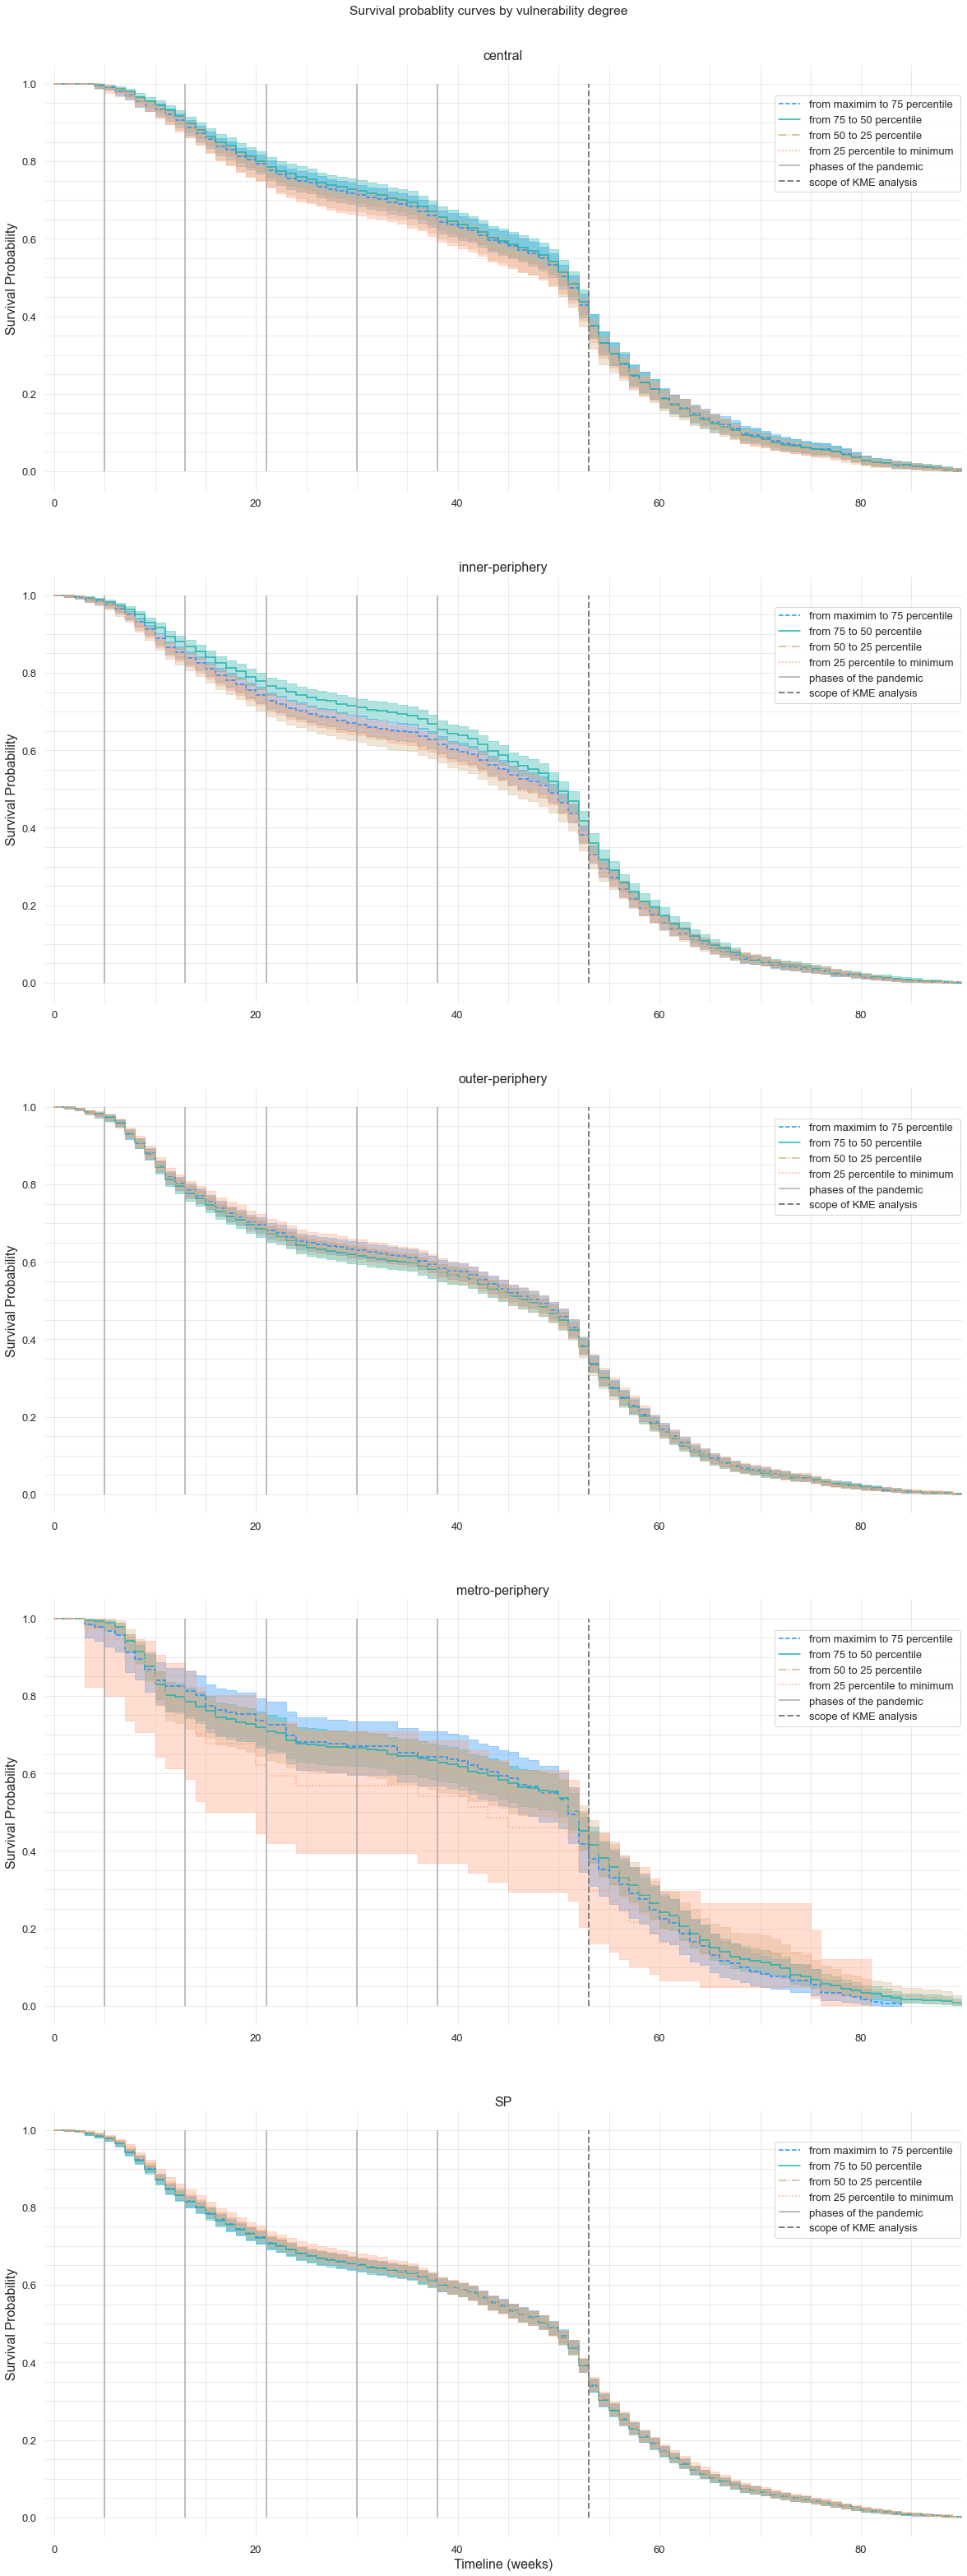

In [334]:
save_fig = True
ci_alpha_value = 0.35
lineStyles = ['--','-','-.',':']
cmap = matplotlib.cm.get_cmap('viridis') # tab10
color_list = ['dodgerblue','lightseagreen','tan','lightsalmon','salmon']
#setting font sizes
ss = 13
ms = 16
ls = 18
plt.rc('font', size=ss)          # controls default text sizes
plt.rc('axes', titlesize=ms)     # fontsize of the axes title
plt.rc('axes', labelsize=ms)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=ss)    # fontsize of the tick labels
plt.rc('ytick', labelsize=ss)    # fontsize of the tick labels
plt.rc('legend', fontsize=ss)    # legend fontsize
vlines_pos = [5,13,21,30,38]

fig,ax = plt.subplots(nrows=5, ncols=1, figsize=(20,50), squeeze=True, sharey=True)#,gridspec_kw=dict(right=0.9)
fig.suptitle('Survival probablity curves by vulnerability degree')
fig.subplots_adjust(top=0.96)

dict_df_lists = {'central':[svi_cen_75_max_df, svi_cen_75_50_df, svi_cen_50_25_df, svi_cen_25_min_df],
                 'inner-periphery':[svi_inner_75_max_df, svi_inner_75_50_df, svi_inner_50_25_df, svi_inner_25_min_df],
                 'outer-periphery':[svi_outer_75_max_df, svi_outer_75_50_df, svi_outer_50_25_df, svi_outer_25_min_df],
                 'metro-periphery':[svi_metro_75_max_df, svi_metro_75_50_df, svi_metro_50_25_df, svi_metro_25_min_df],
                 'SP':[svi_SP_75_max_df, svi_SP_75_50_df, svi_SP_50_25_df, svi_SP_25_min_df]}

for i in range(len(svi_reg.index)):
    df1 = dict_df_lists[svi_reg.index[i]][0]
    df2 = dict_df_lists[svi_reg.index[i]][1]
    df3 = dict_df_lists[svi_reg.index[i]][2]
    df4 = dict_df_lists[svi_reg.index[i]][3]
    ii = i-1

    #fitting for allcities at the same time'''
    kmf_ext1 = KaplanMeierFitter() 
    T1 = df1['week']     ## time to event
    E1 = df1['event']      ## event occurred or censored
    label1 = 'from maximim to 75 percentile'  #(n='+str(len(svi_br_75_max_list))+')
    kmf_ext1.fit(T1, E1, label=label1)    #
    ax[i] = kmf_ext1.plot(ci_legend=True, ci_alpha=ci_alpha_value, color=color_list[0],ls=lineStyles[0], ax=ax[i]) #,ax=ax
    
    kmf_ext2 = KaplanMeierFitter() 
    T2 = df2['week']     ## time to event
    E2 = df2['event']      ## event occurred or censored
    label2 = 'from 75 to 50 percentile' #(n='+str(len(svi_br_75_50_list))+')
    kmf_ext2.fit(T2, E2, label=label2)    ## fit the cohort 1 data label=cities_list[i]
    ax[i] = kmf_ext2.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[1],ls=lineStyles[1], ax=ax[i]) #show_censors=True

    kmf_ext3 = KaplanMeierFitter() 
    T3 = df3['week']     ## time to event
    E3 = df3['event']      ## event occurred or censored
    label3 = 'from 50 to 25 percentile' # (n='+str(len(svi_br_50_25_list))+')
    kmf_ext3.fit(T3, E3, label=label3)    ## fit the cohort 1 data label=cities_list[i]
    ax[i] = kmf_ext3.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[2],ls=lineStyles[2], ax=ax[i]) #show_censors=True

    kmf_ext4 = KaplanMeierFitter() 
    T4 = df4['week']     ## time to event
    E4 = df4['event']      ## event occurred or censored
    label4 = 'from 25 percentile to minimum ' #(n='+str(len(svi_br_25_min_list))+')
    kmf_ext4.fit(T4, E4, label=label4)    ## fit the cohort 1 data label=cities_list[i]
    ax[i] = kmf_ext4.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[3],ls=lineStyles[3], ax=ax[i]) #show_censors=True  
        
    ax[i].vlines(vlines_pos, 0, 1, colors='darkgrey',lw=1.5, linestyles='-', label='phases of the pandemic')
    ax[i].vlines([53], 0, 1, colors='grey',lw=2, linestyles='--', label='scope of KME analysis') #
    ax[i].legend(bbox_to_anchor=(0.79, 0.94), loc='upper left', facecolor='white') #
    ax[i].set_facecolor((1,1,1))
    ax[i].set(title = str(svi_reg.index[i]), xlabel='', ylabel='Survival Probability',xlim=[-1,90]) #,\n
#    for i in range(len(vlines_pos)):
#        text((vlines_pos[i]-0.3),1.01,i+1,color='darkgrey')

    for n in range(len(dict_df_lists.keys())):
        ax[n].grid(b=True, which='major', color='#999999', linestyle='-',alpha=0.2)
        ax[n].minorticks_on()
        ax[n].grid(b=True, which='minor', color='#999999', linestyle='-',alpha=0.2)
    
    ax[4].set(xlabel='Timeline (weeks)')

if save_fig == True:
    file_name = 'CVGI_KME_SVI_districts_per_ring_D1.png'
    file_path = Path('./06 imgs/')
    url = file_path / file_name
    plt.savefig(url, dpi=300,bbox_inches='tight',pad_inches=0.05,transparent=False, facecolor='w')

plt.show()

<h3>Different datasets: gdf_rings_cases</h3>

In [335]:
gdf_rings_cases

,ibge_code,ring,geometry,epi_week,new_cases,new_deaths,gender,race,ethnicity,epi_week_date
17812,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.15,1,0,1.0,0.0,0.0,2020-04-19
17813,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.16,1,0,1.0,0.0,0.0,2020-04-26
17814,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.19,0,0,1.0,0.0,0.0,2020-05-17
17815,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.21,2,0,2.0,2.0,0.0,2020-05-31
17816,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.22,0,0,1.0,1.0,0.0,2020-06-07
...,...,...,...,...,...,...,...,...,...,...
792257,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.38,1,0,1.0,1.0,0.0,2021-09-26
792258,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.39,1,0,1.0,1.0,0.0,2021-10-03
792259,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.43,3,0,3.0,3.0,0.0,2021-10-31
792260,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.44,1,0,1.0,1.0,0.0,2021-11-07


<AxesSubplot:>

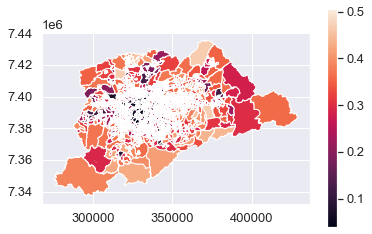

In [337]:
IVS_df.plot('ivs', legend=True)

In [338]:
gdf_rings_cases['reg'] = gdf_rings_cases.apply(lambda row: label_reg(row), axis=1)
gdf_rings_cases

,ibge_code,ring,geometry,epi_week,new_cases,new_deaths,gender,race,ethnicity,epi_week_date,reg
17812,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.15,1,0,1.0,0.0,0.0,2020-04-19,1
17813,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.16,1,0,1.0,0.0,0.0,2020-04-26,1
17814,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.19,0,0,1.0,0.0,0.0,2020-05-17,1
17815,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.21,2,0,2.0,2.0,0.0,2020-05-31,1
17816,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.22,0,0,1.0,1.0,0.0,2020-06-07,1
...,...,...,...,...,...,...,...,...,...,...,...
792257,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.38,1,0,1.0,1.0,0.0,2021-09-26,3
792258,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.39,1,0,1.0,1.0,0.0,2021-10-03,3
792259,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.43,3,0,3.0,3.0,0.0,2021-10-31,3
792260,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.44,1,0,1.0,1.0,0.0,2021-11-07,3


<h3>Distance from center: gdf_rings_cases</h3>

In [523]:
gdf_rings_cases
#Sé district: 3550308
#One of the innermost census tracts of Sé District: 355030878000105


,ibge_code,ring,geometry,end_epi_week,new_cases,new_deaths,gender,race,ethnicity,epi_week_date
17812,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.17,1,0,1.0,0.0,0.0,2020-05-03
17813,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.23,1,0,1.0,1.0,0.0,2020-06-14
17814,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.24,0,0,1.0,0.0,0.0,2020-06-21
17815,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.25,2,0,3.0,2.0,0.0,2020-06-28
17816,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.26,1,0,2.0,1.0,0.0,2020-07-05
...,...,...,...,...,...,...,...,...,...,...
463201,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.36,1,0,1.0,1.0,0.0,2021-09-12
463202,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.37,1,0,1.0,1.0,0.0,2021-09-19
463203,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.39,1,0,3.0,3.0,0.0,2021-10-03
463204,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.40,1,0,1.0,1.0,0.0,2021-10-10


In [369]:
gdf_rmsp.to_crs('EPSG:31983', inplace=True)
gdf_rmsp.crs

<Derived Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [372]:
gdf_rings_cases.to_crs('EPSG:31983', inplace=True)
gdf_rings_cases.crs

<Derived Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - between 48°W and 42°W, northern and southern hemispheres, onshore and offshore.
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [373]:
gdf_rmsp['centroid'] = gdf_rmsp.centroid

In [374]:
gdf_rmsp[gdf_rmsp.CD_SETOR == '355030878000105']

,CD_SETOR,CD_DIST,CD_MUN,NM_MUN,geometry,centroid,dist_center
87189,355030878000105,355030878,3550308,São Paulo,"POLYGON ((333592.929 7394908.653, 333551.172 7...",POINT (333404.894 7394873.837),0.0


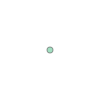

In [375]:
gdf_rmsp['centroid'] = gdf_rmsp.centroid
first_point = gdf_rmsp['centroid'].loc[87189]
first_point

In [533]:
gdf_rings_cases['dist_centre'] = gdf_rings_cases.distance(first_point)
gdf_rings_cases

,ibge_code,ring,geometry,end_epi_week,new_cases,new_deaths,gender,race,ethnicity,epi_week_date,dist_centre
17812,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.17,1,0,1.0,0.0,0.0,2020-05-03,7.402412e+06
17813,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.23,1,0,1.0,1.0,0.0,2020-06-14,7.402412e+06
17814,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.24,0,0,1.0,0.0,0.0,2020-06-21,7.402412e+06
17815,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.25,2,0,3.0,2.0,0.0,2020-06-28,7.402412e+06
17816,355030801000001,central,"POLYGON ((-46.56954 -23.56918, -46.57016 -23.5...",2020.26,1,0,2.0,1.0,0.0,2020-07-05,7.402412e+06
...,...,...,...,...,...,...,...,...,...,...,...
463201,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.36,1,0,1.0,1.0,0.0,2021-09-12,7.402412e+06
463202,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.37,1,0,1.0,1.0,0.0,2021-09-19,7.402412e+06
463203,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.39,1,0,3.0,3.0,0.0,2021-10-03,7.402412e+06
463204,355030896000247,outer-periphery,"POLYGON ((-46.39609 -23.54660, -46.39626 -23.5...",2021.40,1,0,1.0,1.0,0.0,2021-10-10,7.402412e+06


<h4>Plotting deaths x distance (rings DF)</h4>

In [474]:
#maybe look at this: https://stackoverflow.com/questions/23836114/pandas-temporal-cumulative-sum-by-group

In [378]:
gdf_rings_cases.new_deaths.unique()

array([0, 1, 2, 3])

<h4>accumulated cases and deaths</h4>

In [380]:
gdf_rings_cases['acc_deaths'] = 0
gdf_rings_cases['acc_cases'] = 0
gdf_rings_cases.head()

,ibge_code,ring,geometry,epi_week,new_cases,new_deaths,gender,race,ethnicity,epi_week_date,reg,centroid,dist_centre,acc_deaths,acc_cases
17812,355030801000001,central,"POLYGON ((339819.409 7392592.743, 339756.895 7...",2020.15,1,0,1.0,0.0,0.0,2020-04-19,1,POINT (-46.57084 -23.56784),6416.739062,0,0
17813,355030801000001,central,"POLYGON ((339819.409 7392592.743, 339756.895 7...",2020.16,1,0,1.0,0.0,0.0,2020-04-26,1,POINT (-46.57084 -23.56784),6416.739062,0,0
17814,355030801000001,central,"POLYGON ((339819.409 7392592.743, 339756.895 7...",2020.19,0,0,1.0,0.0,0.0,2020-05-17,1,POINT (-46.57084 -23.56784),6416.739062,0,0
17815,355030801000001,central,"POLYGON ((339819.409 7392592.743, 339756.895 7...",2020.21,2,0,2.0,2.0,0.0,2020-05-31,1,POINT (-46.57084 -23.56784),6416.739062,0,0
17816,355030801000001,central,"POLYGON ((339819.409 7392592.743, 339756.895 7...",2020.22,0,0,1.0,1.0,0.0,2020-06-07,1,POINT (-46.57084 -23.56784),6416.739062,0,0


In [385]:
list_tracts = gdf_rings_cases.ibge_code.unique().tolist()
list_tracts[1:10]

['355030801000002',
 '355030801000003',
 '355030801000004',
 '355030801000005',
 '355030801000007',
 '355030801000009',
 '355030801000010',
 '355030801000011',
 '355030801000012']

In [391]:
for tract in list_tracts[1:100]:
    #print(tract)
    gdf_rings_cases['acc_deaths'] = np.where(gdf_rings_cases['ibge_code'].isin([tract]),1,0)
    #df['covid'] = np.where(df['classificacaoFinalModificada'].isin([1, 2, 3, 4]), 1, 0)
    
gdf_rings_cases

,ibge_code,ring,geometry,epi_week,new_cases,new_deaths,gender,race,ethnicity,epi_week_date,reg,centroid,dist_centre,acc_deaths,acc_cases
17812,355030801000001,central,"POLYGON ((339819.409 7392592.743, 339756.895 7...",2020.15,1,0,1.0,0.0,0.0,2020-04-19,1,POINT (-46.57084 -23.56784),6416.739062,0,0
17813,355030801000001,central,"POLYGON ((339819.409 7392592.743, 339756.895 7...",2020.16,1,0,1.0,0.0,0.0,2020-04-26,1,POINT (-46.57084 -23.56784),6416.739062,0,0
17814,355030801000001,central,"POLYGON ((339819.409 7392592.743, 339756.895 7...",2020.19,0,0,1.0,0.0,0.0,2020-05-17,1,POINT (-46.57084 -23.56784),6416.739062,0,0
17815,355030801000001,central,"POLYGON ((339819.409 7392592.743, 339756.895 7...",2020.21,2,0,2.0,2.0,0.0,2020-05-31,1,POINT (-46.57084 -23.56784),6416.739062,0,0
17816,355030801000001,central,"POLYGON ((339819.409 7392592.743, 339756.895 7...",2020.22,0,0,1.0,1.0,0.0,2020-06-07,1,POINT (-46.57084 -23.56784),6416.739062,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792257,355030896000247,outer-periphery,"POLYGON ((357499.038 7395275.985, 357481.817 7...",2021.38,1,0,1.0,1.0,0.0,2021-09-26,3,POINT (-46.39671 -23.54551),23966.777107,0,0
792258,355030896000247,outer-periphery,"POLYGON ((357499.038 7395275.985, 357481.817 7...",2021.39,1,0,1.0,1.0,0.0,2021-10-03,3,POINT (-46.39671 -23.54551),23966.777107,0,0
792259,355030896000247,outer-periphery,"POLYGON ((357499.038 7395275.985, 357481.817 7...",2021.43,3,0,3.0,3.0,0.0,2021-10-31,3,POINT (-46.39671 -23.54551),23966.777107,0,0
792260,355030896000247,outer-periphery,"POLYGON ((357499.038 7395275.985, 357481.817 7...",2021.44,1,0,1.0,1.0,0.0,2021-11-07,3,POINT (-46.39671 -23.54551),23966.777107,0,0


In [377]:
sns.displot(data='gdf_rings_cases', x='new_deaths',y='dist_centre')

ValueError: Could not interpret value `new_deaths` for parameter `x`

<h2>Survival analysis: Cox and distance from city center by microdata</h2>

<h4>preparing the data</h4>

In [131]:
cases

,id,dataNotificacao,idade,sexo,racaCor,etnia,bairro,setorCensitario,classificacaoFinalModificada,evolucaoCaso,dataEncerramento,in_date,end_date,covid,death,epi_week,epi_week_col,CD_DIST
0,1627047285,2020-05-11,56.0,Feminino,Parda,NaN,Vila Vera,355030868000124,5.0,Cura,2020-06-30,2020-05-11,2020-06-30,0,0,2020.20,1,355030868
2,1626898870,2020-05-11,62.0,Feminino,Parda,NaN,JARDIM SAPOPEMBA,355030873000096,2.0,Cura,2020-08-13,2020-05-11,2020-08-13,1,0,2020.20,1,355030873
4,1626639304,2020-06-03,34.0,Masculino,Parda,NaN,JARDIM PAULISTA,355030845000127,6.0,Em tratamento domiciliar,2020-06-05,2020-06-03,2020-06-05,0,0,2020.23,2,355030845
5,1626666391,2020-06-04,52.0,Masculino,Branca,NaN,SAPOPEMBA,355030876000164,2.0,Cura,2020-06-19,2020-06-04,2020-06-19,1,0,2020.23,2,355030876
6,1626666374,2020-06-04,46.0,Masculino,NaN,NaN,CERQUEIRA CESAR,355030845000206,1.0,Cura,2020-08-10,2020-06-04,2020-08-10,1,0,2020.23,2,355030845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398298,1645181544,2021-09-21,55.0,Masculino,Ignorado,NaN,JARDIM PAULISTA,355030845000095,6.0,Ignorado,2021-10-13,2021-09-21,2021-10-13,0,0,2021.38,90,355030845
4398299,1645198920,2021-09-22,28.0,Feminino,Ignorado,NaN,SAO PAULO,355030835000041,1.0,Ignorado,2021-10-19,2021-09-22,2021-10-19,1,0,2021.38,90,355030835
4398306,1645183300,2021-09-28,28.0,Feminino,Ignorado,NaN,PINHEIROS,355030845000168,1.0,Ignorado,2021-10-13,2021-09-28,2021-10-13,1,0,2021.39,93,355030845
4398316,1644978809,2021-10-17,36.0,Masculino,Ignorado,NaN,VILA ROMANA,NaN,2.0,Ignorado,2021-10-29,2021-10-17,2021-10-29,1,0,2021.41,94,nan


In [171]:
cases_geo = cases[cases['setorCensitario'].notna()]
cases_geo.drop(axis=1, columns=['bairro','in_epi_week','end_epi_week'],inplace=True) #ä,'CD_DIST'
cases_geo

,id,idade,sexo,racaCor,etnia,setorCensitario,classificacaoFinalModificada,evolucaoCaso,in_date,end_date,covid,death,in_week_col,end_epi_col
0,1627047285,56.0,Feminino,Parda,NaN,355030868000124,5.0,Cura,2020-05-11,2020-06-30,0,0,1,0
2,1626898870,62.0,Feminino,Parda,NaN,355030873000096,2.0,Cura,2020-05-11,2020-08-13,1,0,1,1
4,1626639304,34.0,Masculino,Parda,NaN,355030845000127,6.0,Em tratamento domiciliar,2020-06-03,2020-06-05,0,0,2,2
5,1626666391,52.0,Masculino,Branca,NaN,355030876000164,2.0,Cura,2020-06-04,2020-06-19,1,0,2,3
6,1626666374,46.0,Masculino,NaN,NaN,355030845000206,1.0,Cura,2020-06-04,2020-08-10,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398279,1637251934,61.0,Masculino,Ignorado,NaN,355030802000025,1.0,Cura,2021-09-06,2021-10-18,1,0,91,74
4398298,1645181544,55.0,Masculino,Ignorado,NaN,355030845000095,6.0,Ignorado,2021-09-21,2021-10-13,0,0,89,98
4398299,1645198920,28.0,Feminino,Ignorado,NaN,355030835000041,1.0,Ignorado,2021-09-22,2021-10-19,1,0,89,74
4398306,1645183300,28.0,Feminino,Ignorado,NaN,355030845000168,1.0,Ignorado,2021-09-28,2021-10-13,1,0,92,98


In [451]:
#sets the duration to equal (end_epi_col - in_epi_col) if that would be > 0, otherwise, duration is set to 0
cases_geo['duration'] = np.where(cases_geo['end_epi_col']>cases_geo['in_week_col'],cases_geo['end_epi_col']-cases_geo['in_week_col'],0)
cases_geo

,id,idade,sexo,racaCor,etnia,setorCensitario,classificacaoFinalModificada,evolucaoCaso,in_date,end_date,covid,death,in_week_col,end_epi_col,duration
0,1627047285,56.0,Feminino,Parda,NaN,355030868000124,5.0,Cura,2020-05-11,2020-06-30,0,0,1,0,0
2,1626898870,62.0,Feminino,Parda,NaN,355030873000096,2.0,Cura,2020-05-11,2020-08-13,1,0,1,1,0
4,1626639304,34.0,Masculino,Parda,NaN,355030845000127,6.0,Em tratamento domiciliar,2020-06-03,2020-06-05,0,0,2,2,0
5,1626666391,52.0,Masculino,Branca,NaN,355030876000164,2.0,Cura,2020-06-04,2020-06-19,1,0,2,3,1
6,1626666374,46.0,Masculino,NaN,NaN,355030845000206,1.0,Cura,2020-06-04,2020-08-10,1,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398279,1637251934,61.0,Masculino,Ignorado,NaN,355030802000025,1.0,Cura,2021-09-06,2021-10-18,1,0,91,74,0
4398298,1645181544,55.0,Masculino,Ignorado,NaN,355030845000095,6.0,Ignorado,2021-09-21,2021-10-13,0,0,89,98,9
4398299,1645198920,28.0,Feminino,Ignorado,NaN,355030835000041,1.0,Ignorado,2021-09-22,2021-10-19,1,0,89,74,0
4398306,1645183300,28.0,Feminino,Ignorado,NaN,355030845000168,1.0,Ignorado,2021-09-28,2021-10-13,1,0,92,98,6


In [172]:
gdf_rmsp['centroid'] = gdf_rmsp.centroid
first_point = gdf_rmsp['centroid'].loc[87189]
gdf_rmsp['dist_center'] = gdf_rmsp.distance(first_point)
gdf_rmsp

,CD_SETOR,CD_DIST,CD_MUN,NM_MUN,geometry,centroid,dist_center
3557,350390105000002,350390105,3503901,Arujá,"POLYGON ((365164.286 7412334.372, 365118.286 7...",POINT (364967.947 7412411.008),35916.105996
3558,350390105000003,350390105,3503901,Arujá,"POLYGON ((365610.151 7412311.349, 365594.640 7...",POINT (365388.046 7412334.513),36180.614689
3559,350390105000004,350390105,3503901,Arujá,"POLYGON ((365551.152 7412059.348, 365563.152 7...",POINT (365462.152 7411835.578),36062.982017
3560,350390105000005,350390105,3503901,Arujá,"POLYGON ((365170.663 7411910.772, 365199.154 7...",POINT (365276.418 7411624.404),35679.166908
3561,350390105000006,350390105,3503901,Arujá,"POLYGON ((365378.932 7411298.396, 365375.682 7...",POINT (365020.069 7411599.841),35535.367637
...,...,...,...,...,...,...,...
99741,355645305000172,355645305,3556453,Vargem Grande Paulista,"POLYGON ((297227.038 7385092.809, 297240.326 7...",POINT (296512.022 7385179.312),37468.661771
99742,355645305000173,355645305,3556453,Vargem Grande Paulista,"POLYGON ((295604.571 7385406.773, 295595.563 7...",POINT (295367.194 7385333.204),38967.803789
99743,355645305000174,355645305,3556453,Vargem Grande Paulista,"POLYGON ((295391.137 7384851.021, 295467.583 7...",POINT (295343.686 7384751.450),38959.036474
99744,355645305000175,355645305,3556453,Vargem Grande Paulista,"POLYGON ((292107.465 7386367.662, 292169.004 7...",POINT (291974.063 7386013.001),41623.302330


Merging the DFs

In [466]:
cases_geo_df = cases_geo.merge(gdf_rmsp, how='left', left_on=['setorCensitario'], right_on=['CD_SETOR'])
cases_geo_df = cases_geo_df[cases_geo_df.CD_SETOR.notna()]
cases_geo_df.drop(axis=1, columns=['classificacaoFinalModificada','etnia','evolucaoCaso','CD_SETOR','CD_DIST','CD_MUN','NM_MUN'], inplace=True)
cases_geo_df.columns = ['id','age', 'sex', 'race', 'census_code','in_date', 'end_date', 'covid', 'death','in_week', 'end_week','duration','geometry', 'centroid', 'dist_center']
print('Original cases DB:',len(cases_geo),'Original GDF:',len(gdf_rmsp),'Final merged DB:', len(cases_geo_df))

Original cases DB: 2116591 Original GDF: 46319 Final merged DB: 1209757


In [467]:
cases_geo_df

,id,age,sex,race,census_code,in_date,end_date,covid,death,in_week,end_week,duration,geometry,centroid,dist_center
1,1626898870,62.0,Feminino,Parda,355030873000096,2020-05-11,2020-08-13,1,0,1,1,0,"POLYGON ((347845.772 7388981.822, 347855.605 7...",POINT (347761.068 7388922.503),15430.057629
3,1626666391,52.0,Masculino,Branca,355030876000164,2020-06-04,2020-06-19,1,0,2,3,1,"POLYGON ((346973.871 7389626.807, 346974.450 7...",POINT (346836.939 7389510.232),14374.287789
11,1627204409,29.0,Masculino,Branca,355030846000171,2020-06-15,2021-01-20,1,0,4,8,4,"POLYGON ((321075.536 7381356.187, 321053.439 7...",POINT (320979.020 7381312.281),18276.272204
15,1626565787,33.0,Feminino,Branca,355030821000083,2020-06-22,2020-06-23,0,0,5,11,6,"POLYGON ((330717.723 7398806.108, 330754.685 7...",POINT (330674.473 7398747.444),4620.815547
17,1628735557,59.0,Masculino,Branca,355030874000078,2020-06-25,2021-06-02,1,0,5,7,2,"POLYGON ((352744.236 7397866.609, 352745.111 7...",POINT (352591.598 7397726.781),19209.134902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116582,1637236028,77.0,Feminino,Branca,355030862000083,2021-09-06,2021-09-20,1,0,91,77,0,"POLYGON ((327437.718 7394779.666, 327433.662 7...",POINT (327466.124 7394593.095),5815.090999
2116583,1637250670,12.0,Feminino,Parda,355030802000042,2021-09-06,2021-10-18,1,0,91,74,0,"POLYGON ((324687.562 7394548.935, 324674.755 7...",POINT (324569.923 7394457.311),8723.384313
2116584,1645343936,47.0,Masculino,Parda,355030844000107,2021-09-01,2021-09-01,1,0,86,88,2,"POLYGON ((354049.575 7401827.159, 354061.333 7...",POINT (353883.529 7401812.945),21435.185590
2116585,1644638716,32.0,Feminino,Ignorado,355030884000002,2021-09-29,2021-09-29,0,0,92,84,0,"POLYGON ((355750.473 7399040.022, 355691.312 7...",POINT (355600.157 7399209.225),22400.209265


In [454]:
cases_geo_df['sex'].value_counts()

Feminino      712558
Masculino     496098
Indefinido      1101
Name: sex, dtype: int64

In [455]:
cases_geo_df['race'].value_counts()

Parda       454429
Branca      453231
Ignorado    145781
Preta        74176
Amarela      28848
Indigena      1385
Name: race, dtype: int64

<h3>generating dummies</h3>

In [468]:
cox_micro_dummies = cases_geo_df[:][['age', 'sex', 'race','covid', 'death',  'in_week','duration','end_week','dist_center']]# 'in_date','in_week_col', 'end_date','geometry', 'centroid',     

In [524]:
dummies_race = {'Branca':0,'Branco':0,'Parda':2,'Preta':3,'Amarela':4,'Indigena':5,'Ignorado':0, np.nan:0} #eliminating 1st category
dummies_sex = {'Feminino':1,'Masculino':0,'Indefinido':0} #eliminating first category
cox_micro_dummies['race'] = cox_micro_dummies['race'].replace(dummies_race)
cox_micro_dummies['sex'] = cox_micro_dummies['sex'].replace(dummies_sex)
cox_micro_dummies['end_week'] = cox_micro_dummies['end_week'] + 0.1
cox_micro_dummies

,age,sex,race,covid,death,in_week,duration,end_week,dist_center
1,62.0,1,2.0,1,0,1,0,1.2,15430.057629
3,52.0,2,1.0,1,0,2,1,3.2,14374.287789
11,29.0,2,1.0,1,0,4,4,8.2,18276.272204
15,33.0,1,1.0,0,0,5,6,11.2,4620.815547
17,59.0,2,1.0,1,0,5,2,7.2,19209.134902
...,...,...,...,...,...,...,...,...,...
2116582,77.0,1,1.0,1,0,91,0,77.2,5815.090999
2116583,12.0,1,2.0,1,0,91,0,74.2,8723.384313
2116584,47.0,2,2.0,1,0,86,2,88.2,21435.185590
2116585,32.0,1,0.0,0,0,92,0,84.2,22400.209265


In [525]:
#checking for NaN values
for col in cox_micro_dummies.columns:
    print(col, cox_micro_dummies[col].isnull().values.any())

age False
sex False
race False
covid False
death False
in_week False
duration False
end_week False
dist_center False


<h4>fitting</h4>

Iteration 1: norm_delta = 1.29600, step_size = 0.1000, log_lik = -29263.93976, newton_decrement = 1764.22484, seconds_since_start = 3.6
Iteration 2: norm_delta = 0.30495, step_size = 0.1000, log_lik = -28961.25440, newton_decrement = 106.90740, seconds_since_start = 7.1
Iteration 3: norm_delta = 0.27286, step_size = 0.1000, log_lik = -28940.94401, newton_decrement = 86.06493, seconds_since_start = 10.7
Iteration 4: norm_delta = 0.23590, step_size = 0.1300, log_lik = -28920.02455, newton_decrement = 64.70160, seconds_since_start = 14.4
Iteration 5: norm_delta = 0.19476, step_size = 0.1690, log_lik = -28900.00714, newton_decrement = 44.36071, seconds_since_start = 18.0
Iteration 6: norm_delta = 0.15102, step_size = 0.2197, log_lik = -28882.66038, newton_decrement = 26.81673, seconds_since_start = 21.6
Iteration 7: norm_delta = 0.10729, step_size = 0.2856, log_lik = -28869.53327, newton_decrement = 13.59473, seconds_since_start = 25.2
Iteration 8: norm_delta = 0.06716, step_size = 0.3713,

<lifelines.CoxPHFitter: fitted with 1.20976e+06 total observations, 1.20755e+06 right-censored observations>
             duration col = 'duration'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 1.20976e+06
number of events observed = 2210
   partial log-likelihood = -28855.98
         time fit was run = 2022-10-27 16:33:22 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
sex           0.48       1.62       0.04             0.40             0.57                 1.49                 1.76
race          0.07       1.07       0.02             0.03             0.11                 1.03                 1.12
dist_center   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

              cmp to     z      p   -log2(p)
covariate                                   
age             0.00 46.39 <0.005        inf
sex             0.00 11.33 <0.005      96.40
race            0.00  3.17 <0.005       9.38
dist_center     0.00 11.19 <0.005      94.10
---
Concordance = 0.69
Partial AIC = 57719.96
log-likelihood ratio test = 815.92 on 4 df
-log2(p) of ll-ratio test = 579.89

<AxesSubplot:xlabel='log(HR) (95% CI)'>

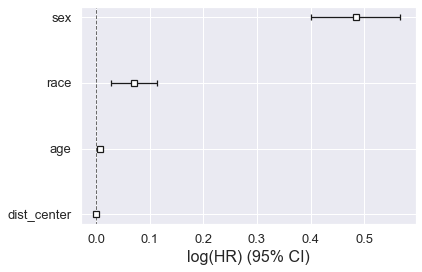

In [526]:
#After creating the dummies, we implement the model:
#We pass three parameters to the model: the dataset (df_dummy), 
#the time column (tenure), and the event column (Churn).
df = cox_micro_dummies[:][['age', 'sex', 'race','death','duration','dist_center']]

cph.fit(df, duration_col='duration', event_col='death',
        show_progress=True,step_size=0.1)   ## Fit the data to train the model 

#The summary presents the statistics
cph.print_summary()

cph.plot()

<h4>exploring partial effects</h4>

In [476]:
cox_micro_dummies.dist_center.describe()

count    1.209757e+06
mean     1.491990e+04
std      5.843959e+03
min      1.821664e+02
25%      1.061288e+04
50%      1.441360e+04
75%      1.922422e+04
max      4.624623e+04
Name: dist_center, dtype: float64

cox_micro_dummies

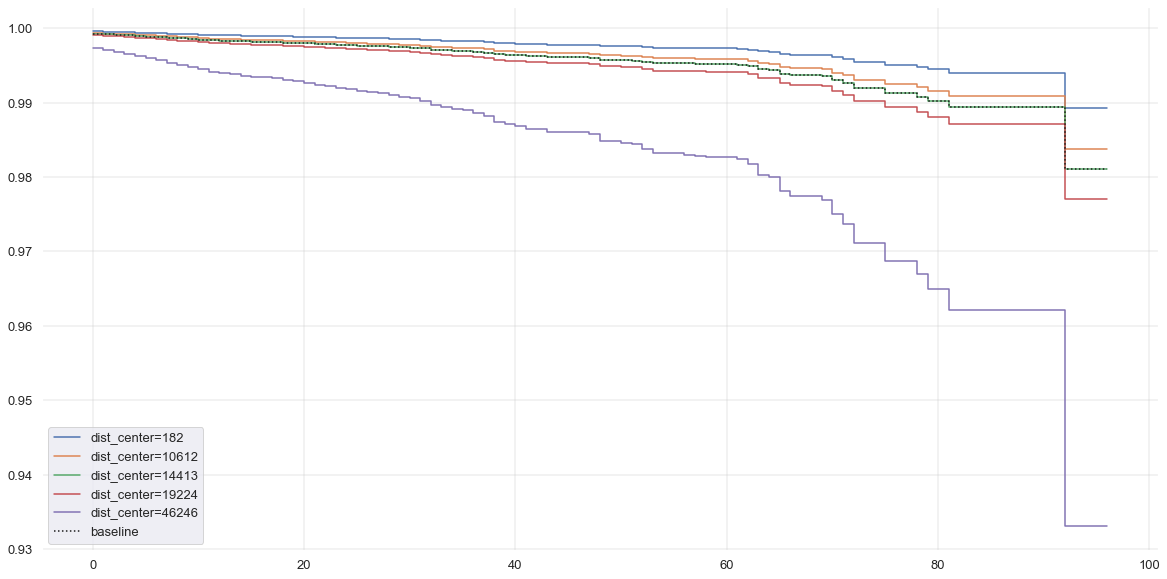

In [527]:
fig,ax = plt.subplots(figsize=(20,10))
ax.set_facecolor((1, 1,1))
cph.plot_partial_effects_on_outcome(covariates=["dist_center"],values=[182,10612,14413,19224,46246],label=['min','Q25','Q50','Q75','max'],plot_baseline=True, ax=ax)
ax.grid(b=True, which='minor', color='silver', linewidth=0.4)
ax.grid(b=True, which='major', color='silver', linewidth=0.4)
plt.show()

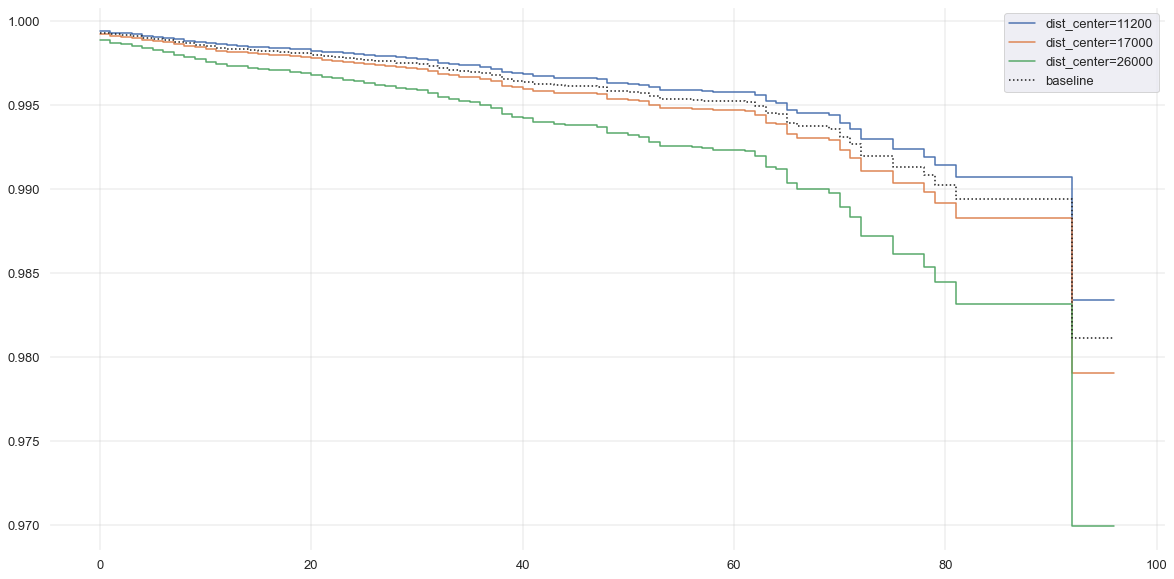

In [483]:
R1 = 11200
R2 = 17000
R3 = 26000
fig,ax = plt.subplots(figsize=(20,10))
ax.set_facecolor((1, 1,1))
cph.plot_partial_effects_on_outcome(covariates=["dist_center"],values=[R1,R2,R3],label=['min','Q25','Q50','Q75','max'],plot_baseline=True, ax=ax)
ax.grid(b=True, which='minor', color='silver', linewidth=0.4)
ax.grid(b=True, which='major', color='silver', linewidth=0.4)
plt.show()

In [462]:
cox_micro_dummies.dist_center.describe()

count    1.209757e+06
mean     1.491990e+04
std      5.843959e+03
min      1.821664e+02
25%      1.061288e+04
50%      1.441360e+04
75%      1.922422e+04
max      4.624623e+04
Name: dist_center, dtype: float64

<h4>KME again</h4>

In [463]:
print('Q10',cox_micro_dummies.dist_center.quantile(q=.10),'\nQ25',cox_micro_dummies.dist_center.quantile(q=.25), '\nQ50',cox_micro_dummies.dist_center.quantile(q=.50),
      '\nQ75',cox_micro_dummies.dist_center.quantile(q=.750),'\nQ90',cox_micro_dummies.dist_center.quantile(q=.90))

Q10 7736.088904889427 
Q25 10612.881759447951 
Q50 14413.600639987133 
Q75 19224.222336332667 
Q90 22991.113195120804


In [449]:
cox_micro_dummies.duration.describe()

count    1.209757e+06
mean     8.647710e+00
std      1.321087e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.100000e+01
max      9.600000e+01
Name: duration, dtype: float64

<AxesSubplot:xlabel='duration', ylabel='Count'>

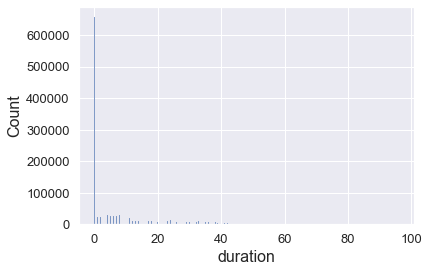

In [464]:
sns.histplot(data=cox_micro_dummies,x='duration')

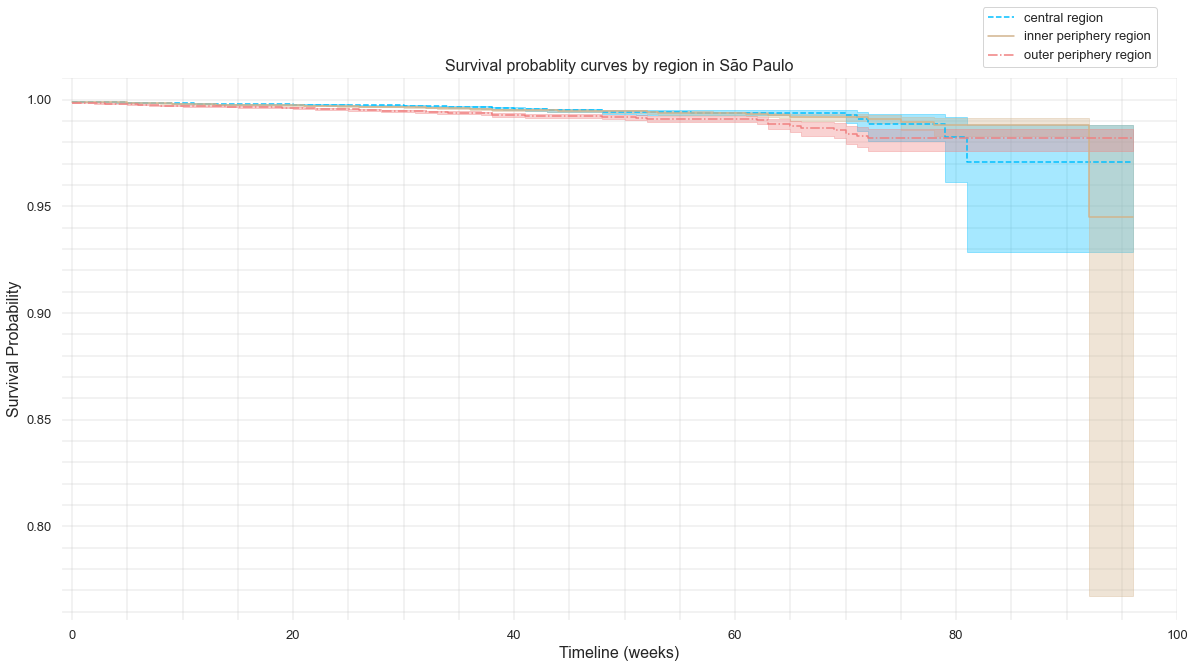

In [465]:
Q1 = 0.25
Q2 = 0.75
df1 = cox_micro_dummies[cox_micro_dummies.dist_center < cox_micro_dummies.dist_center.quantile(q=Q1)] #15% quantile
df2 = cox_micro_dummies[(cox_micro_dummies.dist_center >= cox_micro_dummies.dist_center.quantile(q=Q1)) & (cox_micro_dummies.dist_center < cox_micro_dummies.dist_center.quantile(q=Q2))] #from 15 to 85%
df3 = cox_micro_dummies[cox_micro_dummies.dist_center >= cox_micro_dummies.dist_center.quantile(q=Q2)] #85% quantile

save_fig = False
ci_alpha_value = 0.35
lineStyles = ['--','-','-.',':']
cmap = matplotlib.cm.get_cmap('viridis') # tab10
color_list = ['deepskyblue','tan','lightcoral','lightsalmon','salmon'] #['dodgerblue','lightseagreen','tan','lightsalmon','salmon']
#setting font sizes
ss = 13
ms = 16
ls = 18
#vlines_pos = [5,13,21,30,38,53,65,75] 
#vlines_pos_dict = {5:'22.02.2020',13:'25.04.2020',21:'27.06.2020',30:'29.08.2020',
#                   38:'24.10.2020',53:'06.02.2021',65:'01.05.2021',75:'16.10.2021'} #these are the actual dates for reference

plt.rc('font', size=ss)          # controls default text sizes
plt.rc('axes', titlesize=ms)     # fontsize of the axes title
plt.rc('axes', labelsize=ms)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=ss)    # fontsize of the tick labels
plt.rc('ytick', labelsize=ss)    # fontsize of the tick labels
plt.rc('legend', fontsize=ss)    # legend fontsize

fig,ax = plt.subplots(figsize=(20,10))#,gridspec_kw=dict(right=0.9)
ax.set_facecolor((1, 1,1))

#fitting the model
kmf_ext1 = KaplanMeierFitter() 
T1 = df1['duration']     ## time to event
E1 = df1['death']      ## event occurred or censored
label1 = 'central region'
kmf_ext1.fit(T1, E1, label=label1)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext1.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[0],ls=lineStyles[0])

kmf_ext2 = KaplanMeierFitter() 
T2 = df2['duration']     ## time to event
E2 = df2['death']      ## event occurred or censored
label2 = 'inner periphery region'
kmf_ext2.fit(T2, E2, label=label2)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext2.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[1],ls=lineStyles[1]) #show_censors=True

kmf_ext3 = KaplanMeierFitter() 
T3 = df3['duration']     ## time to event
E3 = df3['death']      ## event occurred or censored
label3 = 'outer periphery region'
kmf_ext3.fit(T3, E3, label=label3)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext3.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[2],ls=lineStyles[2]) #show_censors=True

plt.minorticks_on()
ax.grid(b=True, which='minor', color='silver', linewidth=0.4)
ax.grid(b=True, which='major', color='silver', linewidth=0.4)
ax.set(title = "Survival probablity curves by region in São Paulo", xlabel='Timeline (weeks)', 
       ylabel='Survival Probability',xlim=[-1,100])#\n
#plt.setp(ax.get_xticklabels(), rotation = 0)

#ax.vlines([90], 0, 1, colors='grey',lw=2, linestyles='--') #, label='scope of KME analysis'
#ax.text(89.7,-0.02,'16.10.2021 \n(scope of analysis)',color='black',ha='center',va='top')
#ax.text(-0.235,-0.06,'(04/01/2020)',color='black')
#ax.text(101,-0.06,'(30/11/2021)',color='black',ha='right')
#for i in range(len(vlines_pos)):
#    ax.text((vlines_pos[i]-0.2),-0.03,vlines_pos_dict[vlines_pos[i]],color='black',ha='center',va='top')  #i+1
#ax.vlines(vlines_pos, 0, 1, colors='grey',lw=1.5, linestyles='-', label='phases of the pandemic')

#fig.suptitle('Survival probablity curves by vulnerability degree')
plt.legend(bbox_to_anchor=(0.82, 1.14), loc='upper left', facecolor='white') #legend comes last to catch all elements from plot and phases of the pandemic

if save_fig == True:
    file_name = 'CVGI_KME_SVI_districts_per_ring_D3.png'
    file_path = Path('./OUT/')
    url = file_path / file_name
    plt.savefig(url, dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()

<h3>The high survival probability above might be a problem. Let's try to work only with deaths.</h3>

In [438]:
cases_dead = cases_geo[cases_geo.death == 1]
print('Deaths',len(cases_dead), 'versus all cases',len(cases_geo))

Deaths 3599 versus all cases 2116591


In [439]:
death_geo_df = cases_dead.merge(gdf_rmsp, how='left', left_on=['setorCensitario'], right_on=['CD_SETOR'])
death_geo_df = death_geo_df[death_geo_df.CD_SETOR.notna()]
death_geo_df.drop(axis=1, columns=['classificacaoFinalModificada','etnia','evolucaoCaso','CD_SETOR','CD_DIST','CD_MUN','NM_MUN'], inplace=True)
death_geo_df.columns = ['id','age', 'sex', 'race', 'census_code','in_date', 'end_date', 'covid', 'death','in_week', 'end_week','duration','geometry', 'centroid', 'dist_center']
print('Original cases DB:',len(cases_dead),'Original GDF:',len(gdf_rmsp),'Final merged DB:', len(death_geo_df))


Original cases DB: 3599 Original GDF: 46319 Final merged DB: 2210


In [440]:
cox_death_dummies = death_geo_df[:][['age', 'sex', 'race','covid', 'death',  'in_week','duration','end_week','dist_center']]# 'in_date','in_week_col', 'end_date','geometry', 'centroid',     

In [441]:
dummies_race = {'Branca':1,'Branco':1,'Parda':2,'Preta':3,'Amarela':4,'Indigena':5,'Ignorado':0, np.nan:0}
dummies_sex = {'Feminino':1,'Masculino':2,'Indefinido':0}
cox_death_dummies['race'] = cox_death_dummies['race'].replace(dummies_race)
cox_death_dummies['sex'] = cox_death_dummies['sex'].replace(dummies_sex)
cox_death_dummies['end_week'] = cox_death_dummies['end_week'] + 0.1
cox_death_dummies


,age,sex,race,covid,death,in_week,duration,end_week,dist_center
0,76.0,2,2.0,0,1,23,32,55.1,16364.213750
1,40.0,2,0.0,0,1,24,31,55.1,24544.727273
2,42.0,2,0.0,1,1,4,1,5.1,999.217436
3,54.0,2,0.0,0,1,24,1,2.1,13175.635733
4,62.0,1,0.0,0,1,16,48,64.1,5660.484282
...,...,...,...,...,...,...,...,...,...
3583,74.0,1,2.0,0,1,86,1,85.1,13725.568097
3586,1.0,1,2.0,1,1,86,1,78.1,16604.394280
3591,91.0,1,3.0,1,1,86,1,78.1,14247.705043
3594,43.0,2,1.0,1,1,91,1,90.1,23813.544685


In [442]:
#checking for NaN values
for col in cox_death_dummies.columns:
    print(col, cox_death_dummies[col].isnull().values.any())

age False
sex False
race False
covid False
death False
in_week False
duration False
end_week False
dist_center False


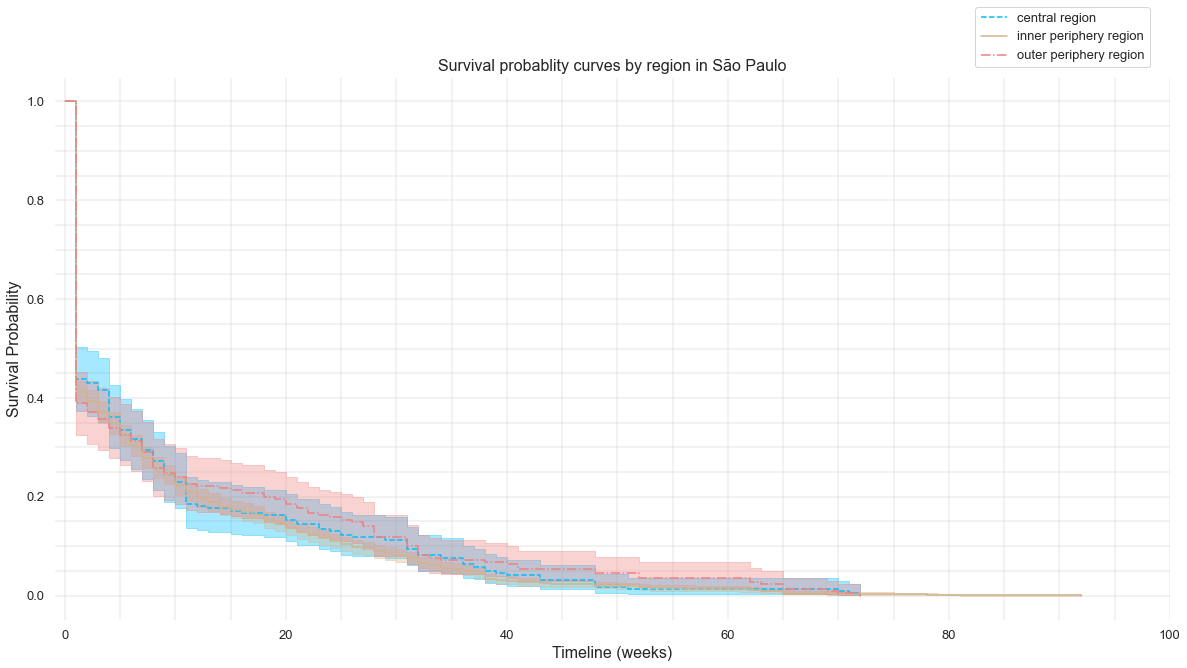

In [443]:
Q1 = 0.10
Q2 = 0.90
df1 = cox_death_dummies[cox_death_dummies.dist_center < cox_death_dummies.dist_center.quantile(q=Q1)] #15% quantile
df2 = cox_death_dummies[(cox_death_dummies.dist_center >= cox_death_dummies.dist_center.quantile(q=Q1)) & (cox_death_dummies.dist_center < cox_death_dummies.dist_center.quantile(q=Q2))] #from 15 to 85%
df3 = cox_death_dummies[cox_death_dummies.dist_center >= cox_death_dummies.dist_center.quantile(q=Q2)] #85% quantile

save_fig = False
ci_alpha_value = 0.35
lineStyles = ['--','-','-.',':']
cmap = matplotlib.cm.get_cmap('viridis') # tab10
color_list = ['deepskyblue','tan','lightcoral','lightsalmon','salmon'] #['dodgerblue','lightseagreen','tan','lightsalmon','salmon']
#setting font sizes
ss = 13
ms = 16
ls = 18
#vlines_pos = [5,13,21,30,38,53,65,75] 
#vlines_pos_dict = {5:'22.02.2020',13:'25.04.2020',21:'27.06.2020',30:'29.08.2020',
#                   38:'24.10.2020',53:'06.02.2021',65:'01.05.2021',75:'16.10.2021'} #these are the actual dates for reference

plt.rc('font', size=ss)          # controls default text sizes
plt.rc('axes', titlesize=ms)     # fontsize of the axes title
plt.rc('axes', labelsize=ms)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=ss)    # fontsize of the tick labels
plt.rc('ytick', labelsize=ss)    # fontsize of the tick labels
plt.rc('legend', fontsize=ss)    # legend fontsize

fig,ax = plt.subplots(figsize=(20,10))#,gridspec_kw=dict(right=0.9)
ax.set_facecolor((1, 1,1))

#fitting the model
kmf_ext1 = KaplanMeierFitter() 
T1 = df1['duration']     ## time to event
E1 = df1['death']      ## event occurred or censored
label1 = 'central region'
kmf_ext1.fit(T1, E1, label=label1)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext1.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[0],ls=lineStyles[0])

kmf_ext2 = KaplanMeierFitter() 
T2 = df2['duration']     ## time to event
E2 = df2['death']      ## event occurred or censored
label2 = 'inner periphery region'
kmf_ext2.fit(T2, E2, label=label2)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext2.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[1],ls=lineStyles[1]) #show_censors=True

kmf_ext3 = KaplanMeierFitter() 
T3 = df3['duration']     ## time to event
E3 = df3['death']      ## event occurred or censored
label3 = 'outer periphery region'
kmf_ext3.fit(T3, E3, label=label3)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext3.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[2],ls=lineStyles[2]) #show_censors=True

plt.minorticks_on()
ax.grid(b=True, which='minor', color='silver', linewidth=0.4)
ax.grid(b=True, which='major', color='silver', linewidth=0.4)
ax.set(title = "Survival probablity curves by region in São Paulo", xlabel='Timeline (weeks)', 
       ylabel='Survival Probability',xlim=[-1,100])#\n
#plt.setp(ax.get_xticklabels(), rotation = 0)

#ax.vlines([90], 0, 1, colors='grey',lw=2, linestyles='--') #, label='scope of KME analysis'
#ax.text(89.7,-0.02,'16.10.2021 \n(scope of analysis)',color='black',ha='center',va='top')
#ax.text(-0.235,-0.06,'(04/01/2020)',color='black')
#ax.text(101,-0.06,'(30/11/2021)',color='black',ha='right')
#for i in range(len(vlines_pos)):
#    ax.text((vlines_pos[i]-0.2),-0.03,vlines_pos_dict[vlines_pos[i]],color='black',ha='center',va='top')  #i+1
#ax.vlines(vlines_pos, 0, 1, colors='grey',lw=1.5, linestyles='-', label='phases of the pandemic')

#fig.suptitle('Survival probablity curves by vulnerability degree')
plt.legend(bbox_to_anchor=(0.82, 1.14), loc='upper left', facecolor='white') #legend comes last to catch all elements from plot and phases of the pandemic

if save_fig == True:
    file_name = 'CVGI_KME_SVI_districts_per_ring_D3.png'
    file_path = Path('./OUT/')
    url = file_path / file_name
    plt.savefig(url, dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()

Testing with rings (based on distance)

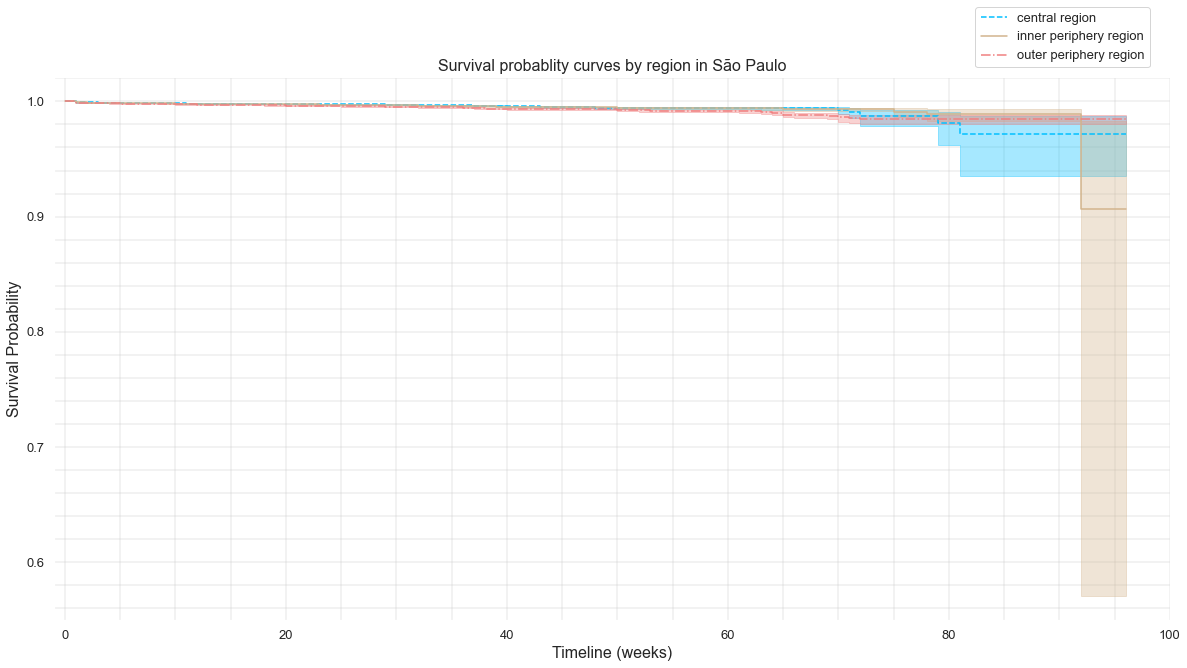

In [444]:
R1 = 11200
R2 = 17000
R3 = 26000
df1 = cox_micro_dummies[cox_micro_dummies.dist_center < R1] #central region
df2 = cox_micro_dummies[(cox_micro_dummies.dist_center >= R1) & (cox_micro_dummies.dist_center < R2)] #inner periphery
df3 = cox_micro_dummies[(cox_micro_dummies.dist_center >= R2) & (cox_micro_dummies.dist_center < R3)] #outer periphery, other sectors are ignored

save_fig = False
ci_alpha_value = 0.35
lineStyles = ['--','-','-.',':']
cmap = matplotlib.cm.get_cmap('viridis') # tab10
color_list = ['deepskyblue','tan','lightcoral','lightsalmon','salmon'] #['dodgerblue','lightseagreen','tan','lightsalmon','salmon']
#setting font sizes
ss = 13
ms = 16
ls = 18
#vlines_pos = [5,13,21,30,38,53,65,75] 
#vlines_pos_dict = {5:'22.02.2020',13:'25.04.2020',21:'27.06.2020',30:'29.08.2020',
#                   38:'24.10.2020',53:'06.02.2021',65:'01.05.2021',75:'16.10.2021'} #these are the actual dates for reference

plt.rc('font', size=ss)          # controls default text sizes
plt.rc('axes', titlesize=ms)     # fontsize of the axes title
plt.rc('axes', labelsize=ms)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=ss)    # fontsize of the tick labels
plt.rc('ytick', labelsize=ss)    # fontsize of the tick labels
plt.rc('legend', fontsize=ss)    # legend fontsize

fig,ax = plt.subplots(figsize=(20,10))#,gridspec_kw=dict(right=0.9)
ax.set_facecolor((1, 1,1))

#fitting the model
kmf_ext1 = KaplanMeierFitter() 
T1 = df1['duration']     ## time to event
E1 = df1['death']      ## event occurred or censored
label1 = 'central region'
kmf_ext1.fit(T1, E1, label=label1)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext1.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[0],ls=lineStyles[0])

kmf_ext2 = KaplanMeierFitter() 
T2 = df2['duration']     ## time to event
E2 = df2['death']      ## event occurred or censored
label2 = 'inner periphery region'
kmf_ext2.fit(T2, E2, label=label2)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext2.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[1],ls=lineStyles[1]) #show_censors=True

kmf_ext3 = KaplanMeierFitter() 
T3 = df3['duration']     ## time to event
E3 = df3['death']      ## event occurred or censored
label3 = 'outer periphery region'
kmf_ext3.fit(T3, E3, label=label3)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext3.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[2],ls=lineStyles[2]) #show_censors=True

plt.minorticks_on()
ax.grid(b=True, which='minor', color='silver', linewidth=0.4)
ax.grid(b=True, which='major', color='silver', linewidth=0.4)
ax.set(title = "Survival probablity curves by region in São Paulo", xlabel='Timeline (weeks)', 
       ylabel='Survival Probability',xlim=[-1,100])#\n
#plt.setp(ax.get_xticklabels(), rotation = 0)

#ax.vlines([90], 0, 1, colors='grey',lw=2, linestyles='--') #, label='scope of KME analysis'
#ax.text(89.7,-0.02,'16.10.2021 \n(scope of analysis)',color='black',ha='center',va='top')
#ax.text(-0.235,-0.06,'(04/01/2020)',color='black')
#ax.text(101,-0.06,'(30/11/2021)',color='black',ha='right')
#for i in range(len(vlines_pos)):
#    ax.text((vlines_pos[i]-0.2),-0.03,vlines_pos_dict[vlines_pos[i]],color='black',ha='center',va='top')  #i+1
#ax.vlines(vlines_pos, 0, 1, colors='grey',lw=1.5, linestyles='-', label='phases of the pandemic')

#fig.suptitle('Survival probablity curves by vulnerability degree')
plt.legend(bbox_to_anchor=(0.82, 1.14), loc='upper left', facecolor='white') #legend comes last to catch all elements from plot and phases of the pandemic

if save_fig == True:
    file_name = 'CVGI_KME_SVI_districts_per_ring_D3.png'
    file_path = Path('./OUT/')
    url = file_path / file_name
    plt.savefig(url, dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()

<h3>Segregating in time: before and after week 53</h3>

In [528]:
cox_micro_dummies_t1 = cox_micro_dummies[cox_micro_dummies.end_week < 53]
cox_micro_dummies_t1

,age,sex,race,covid,death,in_week,duration,end_week,dist_center
1,62.0,1,2.0,1,0,1,0,1.2,15430.057629
3,52.0,2,1.0,1,0,2,1,3.2,14374.287789
11,29.0,2,1.0,1,0,4,4,8.2,18276.272204
15,33.0,1,1.0,0,0,5,6,11.2,4620.815547
17,59.0,2,1.0,1,0,5,2,7.2,19209.134902
...,...,...,...,...,...,...,...,...,...
2108600,32.0,1,0.0,0,0,91,0,6.2,15925.895166
2108663,40.0,1,0.0,1,0,91,0,38.2,18445.544259
2109650,79.0,1,1.0,0,0,91,0,38.2,13174.637296
2113093,54.0,1,1.0,1,0,91,0,9.2,16970.261961


Iteration 1: norm_delta = 1.30032, step_size = 0.1000, log_lik = -19705.11490, newton_decrement = 1277.03975, seconds_since_start = 2.3
Iteration 2: norm_delta = 0.27949, step_size = 0.1000, log_lik = -19509.14154, newton_decrement = 65.92327, seconds_since_start = 4.5
Iteration 3: norm_delta = 0.25035, step_size = 0.1000, log_lik = -19496.61679, newton_decrement = 53.22311, seconds_since_start = 6.8
Iteration 4: norm_delta = 0.21669, step_size = 0.1300, log_lik = -19483.67916, newton_decrement = 40.15298, seconds_since_start = 9.0
Iteration 5: norm_delta = 0.17912, step_size = 0.1690, log_lik = -19471.25527, newton_decrement = 27.64821, seconds_since_start = 11.3
Iteration 6: norm_delta = 0.13907, step_size = 0.2197, log_lik = -19460.44199, newton_decrement = 16.80082, seconds_since_start = 13.6
Iteration 7: norm_delta = 0.09891, step_size = 0.2856, log_lik = -19452.21583, newton_decrement = 8.57008, seconds_since_start = 15.8
Iteration 8: norm_delta = 0.06197, step_size = 0.3713, log

<lifelines.CoxPHFitter: fitted with 762987 total observations, 761462 right-censored observations>
             duration col = 'duration'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 762987
number of events observed = 1525
   partial log-likelihood = -19443.64
         time fit was run = 2022-10-27 16:43:30 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
sex           0.46       1.58       0.05             0.36             0.56                 1.43                 1.75
race          0.09       1.10       0.03             0.04             0.14                 1.04                 1.16
dist_center   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

              cmp to     z      p   -log2(p)
covariate                                   
age             0.00 36.58 <0.005     970.81
sex             0.00  8.94 <0.005      61.15
race            0.00  3.59 <0.005      11.58
dist_center     0.00  7.77 <0.005      46.84
---
Concordance = 0.69
Partial AIC = 38895.27
log-likelihood ratio test = 522.96 on 4 df
-log2(p) of ll-ratio test = 369.20

<AxesSubplot:xlabel='log(HR) (95% CI)'>

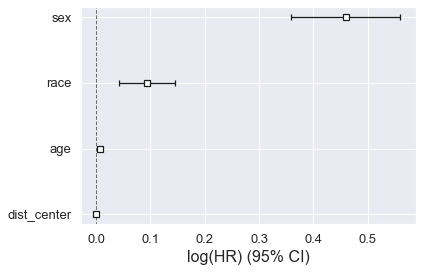

In [529]:
#After creating the dummies, we implement the model:
#We pass three parameters to the model: the dataset (df_dummy), the time column (tenure), and the event column (Churn).
df = cox_micro_dummies_t1[:][['age', 'sex', 'race','death','duration','dist_center']]

cph_t1 = cph.fit(df, duration_col='duration', event_col='death',show_progress=True,step_size=0.1)   ## Fit the data to train the model #,,entry_col = 'in_week'

#The summary presents the statistics
cph_t1.print_summary()

cph_t1.plot()

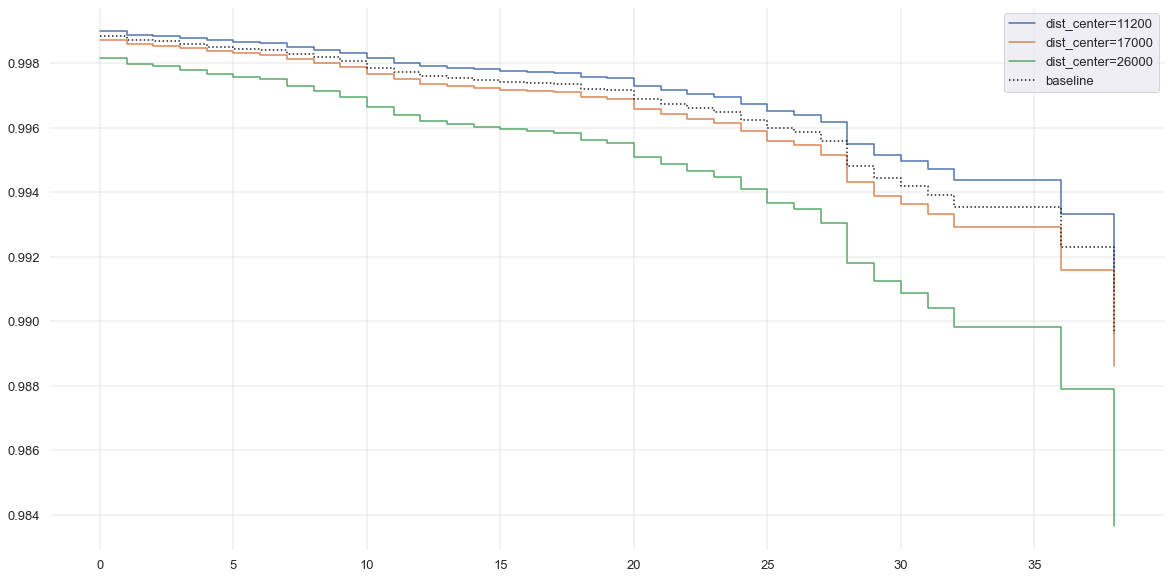

In [508]:
R1 = 11200
R2 = 17000
R3 = 26000
fig,ax = plt.subplots(figsize=(20,10))
ax.set_facecolor((1, 1,1))
cph_t1.plot_partial_effects_on_outcome(covariates=["dist_center"],values=[R1,R2,R3],label=['min','Q25','Q50','Q75','max'],plot_baseline=True, ax=ax)
ax.grid(b=True, which='minor', color='silver', linewidth=0.4)
ax.grid(b=True, which='major', color='silver', linewidth=0.4)
plt.show()

In [530]:
cox_micro_dummies_t2 = cox_micro_dummies[cox_micro_dummies.end_week >= 53]
cox_micro_dummies_t2

,age,sex,race,covid,death,in_week,duration,end_week,dist_center
264,31.0,1,2.0,1,0,20,33,53.2,33778.639055
308,62.0,2,2.0,0,0,25,31,56.2,10123.736865
311,71.0,1,0.0,0,0,25,30,55.2,6045.084008
314,44.0,1,0.0,0,0,26,32,58.2,3285.185096
316,18.0,2,0.0,0,0,26,32,58.2,8825.593629
...,...,...,...,...,...,...,...,...,...
2116582,77.0,1,1.0,1,0,91,0,77.2,5815.090999
2116583,12.0,1,2.0,1,0,91,0,74.2,8723.384313
2116584,47.0,2,2.0,1,0,86,2,88.2,21435.185590
2116585,32.0,1,0.0,0,0,92,0,84.2,22400.209265


Iteration 1: norm_delta = 1.24124, step_size = 0.1000, log_lik = -8230.14895, newton_decrement = 462.86021, seconds_since_start = 1.3
Iteration 2: norm_delta = 0.99725, step_size = 0.1000, log_lik = -8142.32962, newton_decrement = 332.00902, seconds_since_start = 2.7
Iteration 3: norm_delta = 0.67767, step_size = 0.1000, log_lik = -8079.50746, newton_decrement = 196.24744, seconds_since_start = 4.1
Iteration 4: norm_delta = 0.38871, step_size = 0.1300, log_lik = -8032.36344, newton_decrement = 84.66357, seconds_since_start = 5.4
Iteration 5: norm_delta = 0.25988, step_size = 0.1690, log_lik = -8006.48747, newton_decrement = 38.49068, seconds_since_start = 6.7
Iteration 6: norm_delta = 0.18383, step_size = 0.2197, log_lik = -7991.57381, newton_decrement = 18.11518, seconds_since_start = 8.1
Iteration 7: norm_delta = 0.12423, step_size = 0.2856, log_lik = -7982.77059, newton_decrement = 7.78674, seconds_since_start = 9.4
Iteration 8: norm_delta = 0.07534, step_size = 0.3713, log_lik = -7

<lifelines.CoxPHFitter: fitted with 446770 total observations, 446085 right-censored observations>
             duration col = 'duration'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 446770
number of events observed = 685
   partial log-likelihood = -7975.44
         time fit was run = 2022-10-27 16:44:01 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.02       1.02       0.00             0.02             0.02                 1.02                 1.02
sex           0.56       1.76       0.08             0.41             0.71                 1.51                 2.04
race         -0.01       0.99       0.04            -0.09             0.07                 0.92                 1.08
dist_center   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

              cmp to     z      p   -log2(p)
covariate                                   
age             0.00 34.83 <0.005     880.41
sex             0.00  7.40 <0.005      42.75
race            0.00 -0.17   0.86       0.21
dist_center     0.00  8.21 <0.005      52.06
---
Concordance = 0.74
Partial AIC = 15958.88
log-likelihood ratio test = 509.42 on 4 df
-log2(p) of ll-ratio test = 359.47

<AxesSubplot:xlabel='log(HR) (95% CI)'>

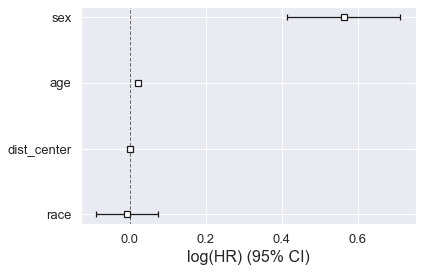

In [531]:
#After creating the dummies, we implement the model:
#We pass three parameters to the model: the dataset (df_dummy), the time column (tenure), and the event column (Churn).
df = cox_micro_dummies_t2[:][['age', 'sex', 'race','death','duration','dist_center']]

cph_t2 = cph.fit(df, duration_col='duration', event_col='death',show_progress=True,step_size=0.1)   ## Fit the data to train the model #,,entry_col = 'in_week'

#The summary presents the statistics
cph_t2.print_summary()

cph_t2.plot()

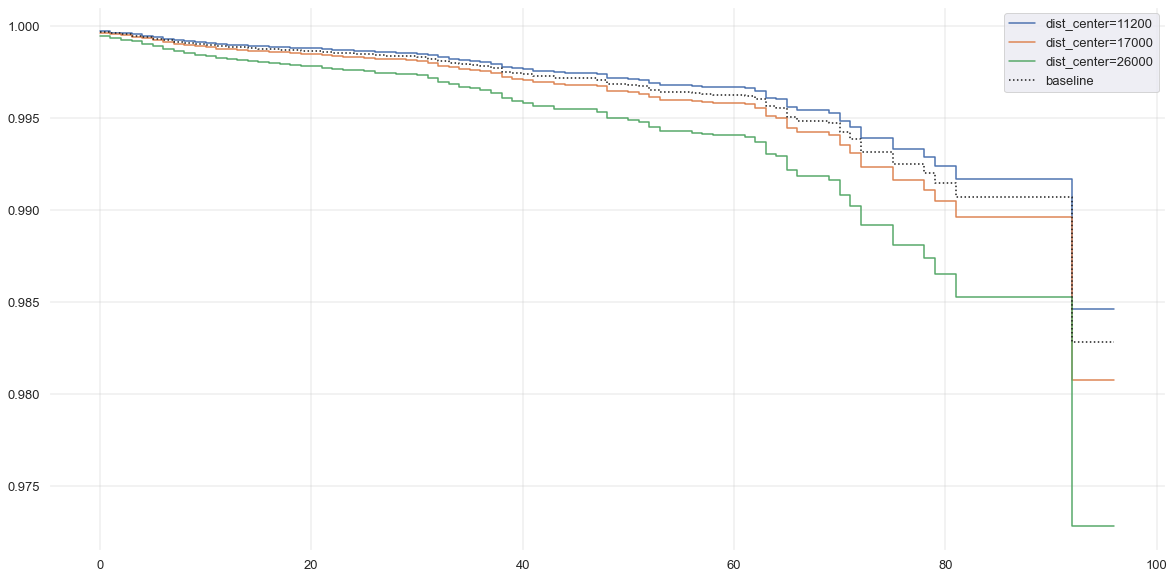

In [511]:
R1 = 11200
R2 = 17000
R3 = 26000
fig,ax = plt.subplots(figsize=(20,10))
ax.set_facecolor((1, 1,1))
cph_t2.plot_partial_effects_on_outcome(covariates=["dist_center"],values=[R1,R2,R3],label=['min','Q25','Q50','Q75','max'],plot_baseline=True, ax=ax)
ax.grid(b=True, which='minor', color='silver', linewidth=0.4)
ax.grid(b=True, which='major', color='silver', linewidth=0.4)
plt.show()

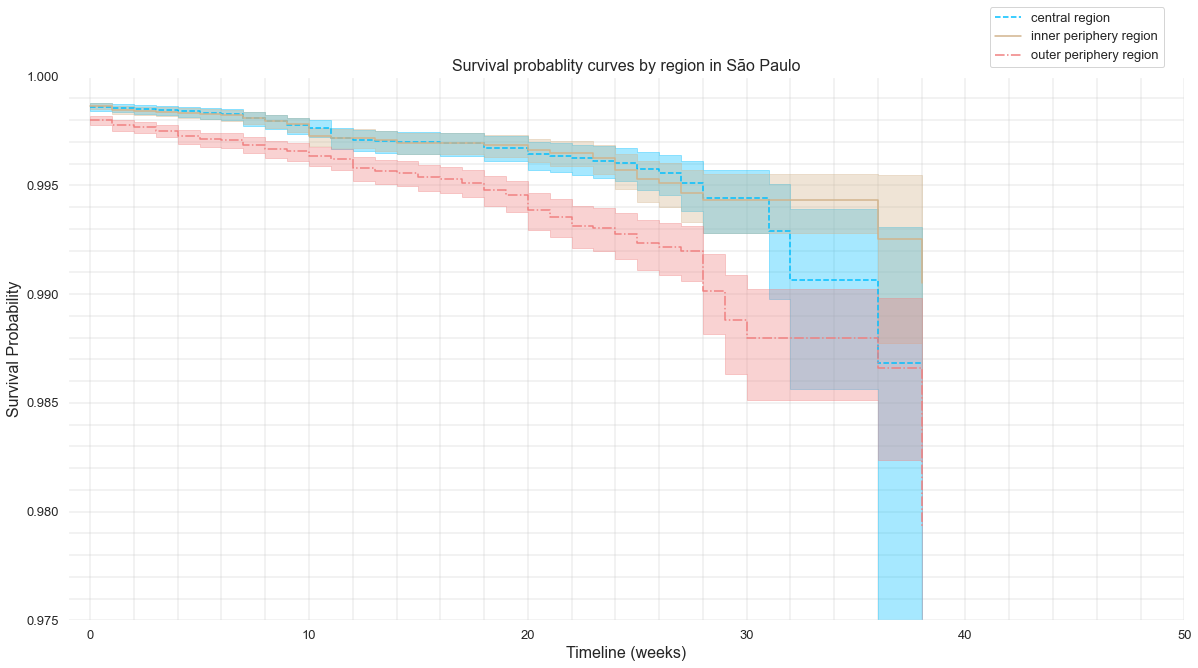

In [512]:
R1 = 11200
R2 = 17000
R3 = 26000
df1 = cox_micro_dummies_t1[cox_micro_dummies_t1.dist_center < R1] #central region
df2 = cox_micro_dummies_t1[(cox_micro_dummies_t1.dist_center >= R1) & (cox_micro_dummies_t1.dist_center < R2)] #inner periphery
df3 = cox_micro_dummies_t1[(cox_micro_dummies_t1.dist_center >= R2) & (cox_micro_dummies_t1.dist_center < R3)] #outer periphery, other sectors are ignored

save_fig = False
ci_alpha_value = 0.35
lineStyles = ['--','-','-.',':']
cmap = matplotlib.cm.get_cmap('viridis') # tab10
color_list = ['deepskyblue','tan','lightcoral','lightsalmon','salmon'] #['dodgerblue','lightseagreen','tan','lightsalmon','salmon']
#setting font sizes
ss = 13
ms = 16
ls = 18
#vlines_pos = [5,13,21,30,38,53,65,75] 
#vlines_pos_dict = {5:'22.02.2020',13:'25.04.2020',21:'27.06.2020',30:'29.08.2020',
#                   38:'24.10.2020',53:'06.02.2021',65:'01.05.2021',75:'16.10.2021'} #these are the actual dates for reference

plt.rc('font', size=ss)          # controls default text sizes
plt.rc('axes', titlesize=ms)     # fontsize of the axes title
plt.rc('axes', labelsize=ms)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=ss)    # fontsize of the tick labels
plt.rc('ytick', labelsize=ss)    # fontsize of the tick labels
plt.rc('legend', fontsize=ss)    # legend fontsize

fig,ax = plt.subplots(figsize=(20,10))#,gridspec_kw=dict(right=0.9)
ax.set_facecolor((1, 1,1))

#fitting the model
kmf_ext1 = KaplanMeierFitter() 
T1 = df1['duration']     ## time to event
E1 = df1['death']      ## event occurred or censored
label1 = 'central region'
kmf_ext1.fit(T1, E1, label=label1)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext1.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[0],ls=lineStyles[0])

kmf_ext2 = KaplanMeierFitter() 
T2 = df2['duration']     ## time to event
E2 = df2['death']      ## event occurred or censored
label2 = 'inner periphery region'
kmf_ext2.fit(T2, E2, label=label2)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext2.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[1],ls=lineStyles[1]) #show_censors=True

kmf_ext3 = KaplanMeierFitter() 
T3 = df3['duration']     ## time to event
E3 = df3['death']      ## event occurred or censored
label3 = 'outer periphery region'
kmf_ext3.fit(T3, E3, label=label3)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext3.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[2],ls=lineStyles[2]) #show_censors=True

plt.minorticks_on()
ax.grid(b=True, which='minor', color='silver', linewidth=0.4)
ax.grid(b=True, which='major', color='silver', linewidth=0.4)
ax.set(title = "Survival probablity curves by region in São Paulo", xlabel='Timeline (weeks)', 
       ylabel='Survival Probability',xlim=[-1,50],ylim=[.975,1])#\n
#plt.setp(ax.get_xticklabels(), rotation = 0)

#ax.vlines([90], 0, 1, colors='grey',lw=2, linestyles='--') #, label='scope of KME analysis'
#ax.text(89.7,-0.02,'16.10.2021 \n(scope of analysis)',color='black',ha='center',va='top')
#ax.text(-0.235,-0.06,'(04/01/2020)',color='black')
#ax.text(101,-0.06,'(30/11/2021)',color='black',ha='right')
#for i in range(len(vlines_pos)):
#    ax.text((vlines_pos[i]-0.2),-0.03,vlines_pos_dict[vlines_pos[i]],color='black',ha='center',va='top')  #i+1
#ax.vlines(vlines_pos, 0, 1, colors='grey',lw=1.5, linestyles='-', label='phases of the pandemic')

#fig.suptitle('Survival probablity curves by vulnerability degree')
plt.legend(bbox_to_anchor=(0.82, 1.14), loc='upper left', facecolor='white') #legend comes last to catch all elements from plot and phases of the pandemic

if save_fig == True:
    file_name = 'CVGI_KME_SVI_districts_per_ring_D3.png'
    file_path = Path('./OUT/')
    url = file_path / file_name
    plt.savefig(url, dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()

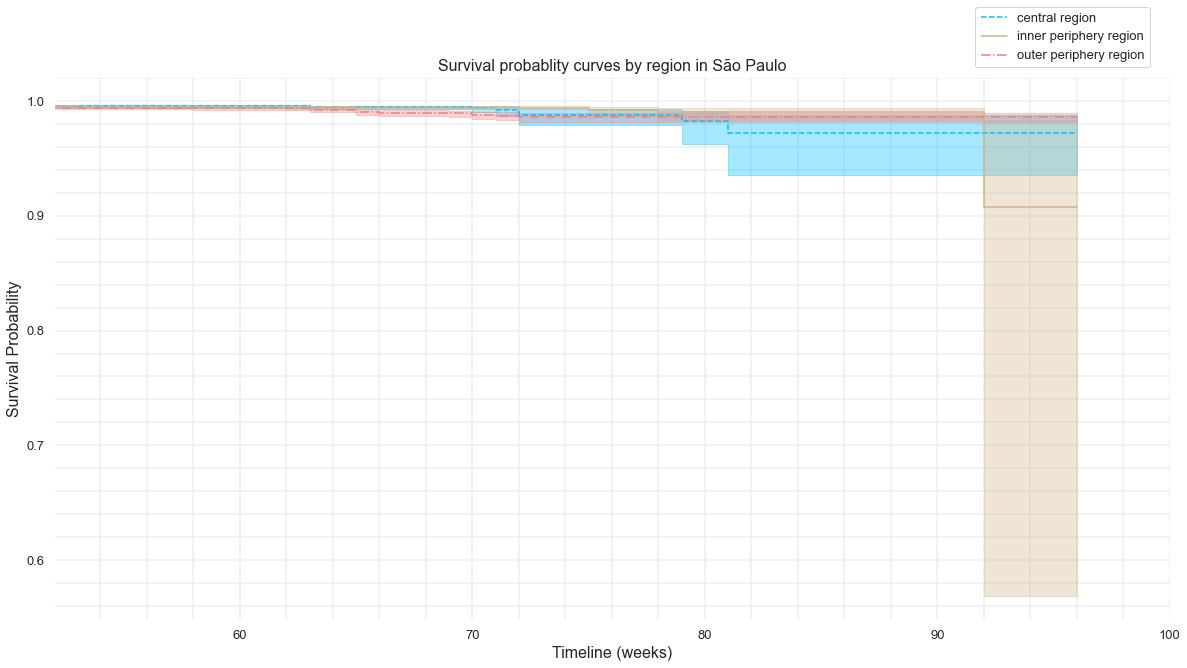

In [513]:
R1 = 11200
R2 = 17000
R3 = 26000
df1 = cox_micro_dummies_t2[cox_micro_dummies_t2.dist_center < R1] #central region
df2 = cox_micro_dummies_t2[(cox_micro_dummies_t2.dist_center >= R1) & (cox_micro_dummies_t2.dist_center < R2)] #inner periphery
df3 = cox_micro_dummies_t2[(cox_micro_dummies_t2.dist_center >= R2) & (cox_micro_dummies_t2.dist_center < R3)] #outer periphery, other sectors are ignored

save_fig = False
ci_alpha_value = 0.35
lineStyles = ['--','-','-.',':']
cmap = matplotlib.cm.get_cmap('viridis') # tab10
color_list = ['deepskyblue','tan','lightcoral','lightsalmon','salmon'] #['dodgerblue','lightseagreen','tan','lightsalmon','salmon']
#setting font sizes
ss = 13
ms = 16
ls = 18
#vlines_pos = [5,13,21,30,38,53,65,75] 
#vlines_pos_dict = {5:'22.02.2020',13:'25.04.2020',21:'27.06.2020',30:'29.08.2020',
#                   38:'24.10.2020',53:'06.02.2021',65:'01.05.2021',75:'16.10.2021'} #these are the actual dates for reference

plt.rc('font', size=ss)          # controls default text sizes
plt.rc('axes', titlesize=ms)     # fontsize of the axes title
plt.rc('axes', labelsize=ms)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=ss)    # fontsize of the tick labels
plt.rc('ytick', labelsize=ss)    # fontsize of the tick labels
plt.rc('legend', fontsize=ss)    # legend fontsize

fig,ax = plt.subplots(figsize=(20,10))#,gridspec_kw=dict(right=0.9)
ax.set_facecolor((1, 1,1))

#fitting the model
kmf_ext1 = KaplanMeierFitter() 
T1 = df1['duration']     ## time to event
E1 = df1['death']      ## event occurred or censored
label1 = 'central region'
kmf_ext1.fit(T1, E1, label=label1)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext1.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[0],ls=lineStyles[0])

kmf_ext2 = KaplanMeierFitter() 
T2 = df2['duration']     ## time to event
E2 = df2['death']      ## event occurred or censored
label2 = 'inner periphery region'
kmf_ext2.fit(T2, E2, label=label2)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext2.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[1],ls=lineStyles[1]) #show_censors=True

kmf_ext3 = KaplanMeierFitter() 
T3 = df3['duration']     ## time to event
E3 = df3['death']      ## event occurred or censored
label3 = 'outer periphery region'
kmf_ext3.fit(T3, E3, label=label3)    ## fit the cohort 1 data label=cities_list[i]
kmf_ext3.plot(ci_legend=True,ci_alpha=ci_alpha_value, color=color_list[2],ls=lineStyles[2]) #show_censors=True

plt.minorticks_on()
ax.grid(b=True, which='minor', color='silver', linewidth=0.4)
ax.grid(b=True, which='major', color='silver', linewidth=0.4)
ax.set(title = "Survival probablity curves by region in São Paulo", xlabel='Timeline (weeks)', 
       ylabel='Survival Probability',xlim=[52,100])#\n
#plt.setp(ax.get_xticklabels(), rotation = 0)

#ax.vlines([90], 0, 1, colors='grey',lw=2, linestyles='--') #, label='scope of KME analysis'
#ax.text(89.7,-0.02,'16.10.2021 \n(scope of analysis)',color='black',ha='center',va='top')
#ax.text(-0.235,-0.06,'(04/01/2020)',color='black')
#ax.text(101,-0.06,'(30/11/2021)',color='black',ha='right')
#for i in range(len(vlines_pos)):
#    ax.text((vlines_pos[i]-0.2),-0.03,vlines_pos_dict[vlines_pos[i]],color='black',ha='center',va='top')  #i+1
#ax.vlines(vlines_pos, 0, 1, colors='grey',lw=1.5, linestyles='-', label='phases of the pandemic')

#fig.suptitle('Survival probablity curves by vulnerability degree')
plt.legend(bbox_to_anchor=(0.82, 1.14), loc='upper left', facecolor='white') #legend comes last to catch all elements from plot and phases of the pandemic

if save_fig == True:
    file_name = 'CVGI_KME_SVI_districts_per_ring_D3.png'
    file_path = Path('./OUT/')
    url = file_path / file_name
    plt.savefig(url, dpi=300,bbox_inches='tight',pad_inches=0.05)
plt.show()

<h3>Instead of duration, end date</h3>

Iteration 1: norm_delta = 1.36046, step_size = 0.1000, log_lik = -29168.95568, newton_decrement = 1963.97393, seconds_since_start = 3.6
Iteration 2: norm_delta = 0.31407, step_size = 0.1000, log_lik = -28811.68638, newton_decrement = 131.40506, seconds_since_start = 7.1
Iteration 3: norm_delta = 0.27978, step_size = 0.1000, log_lik = -28786.73530, newton_decrement = 102.58461, seconds_since_start = 11.0
Iteration 4: norm_delta = 0.24090, step_size = 0.1300, log_lik = -28761.81568, newton_decrement = 75.04328, seconds_since_start = 14.6
Iteration 5: norm_delta = 0.19815, step_size = 0.1690, log_lik = -28738.61421, newton_decrement = 50.25021, seconds_since_start = 18.2
Iteration 6: norm_delta = 0.15315, step_size = 0.2197, log_lik = -28718.97820, newton_decrement = 29.77739, seconds_since_start = 21.8
Iteration 7: norm_delta = 0.10849, step_size = 0.2856, log_lik = -28704.41211, newton_decrement = 14.84965, seconds_since_start = 25.4
Iteration 8: norm_delta = 0.06775, step_size = 0.3713

<lifelines.CoxPHFitter: fitted with 1.20976e+06 total observations, 1.20755e+06 right-censored observations>
             duration col = 'end_week'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 1.20976e+06
number of events observed = 2210
   partial log-likelihood = -28689.71
         time fit was run = 2022-10-27 16:48:55 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
age           0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
sex           0.51       1.67       0.04             0.43             0.60                 1.54                 1.82
race          0.06       1.06       0.02             0.01             0.10                 1.01                 1.11
dist_center   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

              cmp to     z      p   -log2(p)
covariate                                   
age             0.00 54.76 <0.005        inf
sex             0.00 11.98 <0.005     107.42
race            0.00  2.35   0.02       5.74
dist_center     0.00 11.43 <0.005      98.15
---
Concordance = 0.72
Partial AIC = 57387.42
log-likelihood ratio test = 958.49 on 4 df
-log2(p) of ll-ratio test = 682.50

<AxesSubplot:xlabel='log(HR) (95% CI)'>

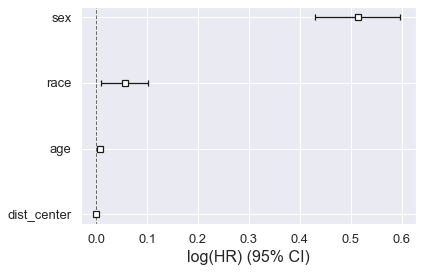

In [532]:
#After creating the dummies, we implement the model:
#We pass three parameters to the model: the dataset (df_dummy), the time column (tenure), and the event column (Churn).
df = cox_micro_dummies[:][['age', 'sex', 'race','death','end_week','dist_center']]

cph.fit(df, duration_col='end_week', event_col='death',show_progress=True,step_size=0.1)   ## Fit the data to train the model #,,entry_col = 'in_week'

#The summary presents the statistics
cph.print_summary()

cph.plot()